# Implement Dropout to Benchmark Ensemble Uncertainties Against

<hr/>

## Prerequisites

#### Imports

In [1]:
import copy
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

from ensemble_uncertainties.model_library import models
from ensemble_uncertainties.evaluators.evaluator_support import format_time_elapsed
from ensemble_uncertainties.evaluators.regression_evaluator import RegressionEvaluator
from ensemble_uncertainties.utils.ad_assessment import rmses_frac

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tqdm import tqdm

#### Constants

In [2]:
RANDOM_SEED = 0
N_PREDS = 100
N_SPLITS = 10
DROPOUT_RATE = .2
TASK = 'regression'
OUTPUT_ACTIVATION = 'linear'
LOSS = 'mse'
METRICS = ['mae', 'mse']
PLOT_FOLDER = './plots/regression/'

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

# Set growth ability of GPU memory (if available)
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

#### Functions

In [4]:
def load_data_set(name, descriptor):
    """Loads X and y as dataframes from data folder."""
    folder = f'../../../data/featurized/{TASK}/{name}/'
    X_file = f'{folder}{name}_{descriptor}.csv'
    y_file = f'{folder}{name}_y.csv'
    X = pd.read_csv(X_file, sep=';').set_index('id')
    y = pd.read_csv(y_file, sep=';').set_index('id')
    return X, y


def preprocess_inputs(X_train, X_test, scale=True):
    """Applies variance threshold and (if scale is set to True) standard scaler."""
    vt = VarianceThreshold().fit(X_train)
    # Do not perform scaling if scale is False
    if scale:
        pre_scaler = StandardScaler()
    else:
        pre_scaler = StandardScaler(with_mean=False, with_std=False)
    scaler = pre_scaler.fit(vt.transform(X_train))
    # Variance-filter and scale train inputs
    X_tr = pd.DataFrame(scaler.transform(vt.transform(X_train)),
        index=X_train.index, columns=X_train.columns[vt.get_support()])
    # Variance-filter and scale test inputs
    X_te = pd.DataFrame(scaler.transform(vt.transform(X_test)),
        index=X_test.index, columns=X_test.columns[vt.get_support()])
    return X_tr, X_te


def deep_architecture_dropout(X, output_activation=OUTPUT_ACTIVATION, dropout_rate=DROPOUT_RATE):
    """Our default deep architecture for property prediction:

    in | 256 ReLU | 128 ReLU | 16 ReLU | 1
    
    Additionally, dropout is performed in every layer.
        
    Parameters
    ----------
    X : DataFrame
        The input data
    output_activation : str
        Name of the activation in the final neuron (tf.keras.activations)
    dropout_rate : float
        The fraction of randomly deactivated weights
            
    Returns
    -------
    function
        A function that takes the number of variables
        (int) and returns the (uncompiled) model
    """
    in_dim = X.shape[1]
    def make_architecture():
        # Create model. To apply dropout during inference,
        # the functional format must be used:
        inp = Input(shape=(in_dim,))
        x = Dropout(dropout_rate)(inp)
        x = Dense(256, activation='relu')(x)
        x = Dropout(dropout_rate)(x, training=True)
        x = Dense(128, activation='relu')(x)
        x = Dropout(dropout_rate)(x, training=True)
        x = Dense(16, activation='relu')(x)
        x = Dropout(dropout_rate)(x, training=True)
        out = Dense(1, activation=output_activation)(x)
        architecture = Model(inp, out)
        architecture.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
        return architecture
    return make_architecture


def predict_using_monte_carlo_dropout(model, X, n_preds=N_PREDS):
    """Predicts outputs for a dataset and a model.
    
    Parameters
    ----------
    model : <object that implements .predict()>
        Fitted neural estimator with dropout
    X : DataFrame
        Set of inputs to predict outputs for
    n_preds : int
        The number of predictions per instance
        
    Returns
    -------
    DataFrame
        Result frame with mean and standard deviation
    """
    pred_df = pd.DataFrame()
    predictions = np.array([model.predict(X) for _ in range(n_preds)])
    predictions = predictions[:, :, 0]
    means = predictions.mean(axis=0)
    sdevs = predictions.std(axis=0)
    for i, pred_line in enumerate(predictions):
        pred_df[f'{i}'] = pred_line
    pred_df['mean'] = means
    pred_df['sdev'] = sdevs
    pred_df.index = X.index
    return pred_df


def plot_r2(trues, preds, ax):
    """Plots true vs. predicted values scatter plot into a given axis object."""
    # Get data from evaluator
    r2 = r2_score(trues, preds)
    # Get corner values of the outputs/predictions
    smallest = min(min(trues.values), min(preds.values))
    biggest = max(min(trues.values), max(preds.values))
    # Plot
    ax.grid(zorder=1000)
    ax.plot(trues, preds, 'o', zorder=101, markersize=4, label=None,
        color='C0', mfc='none', alpha=.7)
    ax.scatter([], [], label=f'$R^2$: {r2:.3f}',
        color='C0', facecolor='none')
    ax.plot([smallest-.2, biggest+.2], [smallest-.2, biggest+.2], zorder=100,
        color='k', label='$\hat{y}$ = $y$')
    ax.set_xlim(smallest-.2, biggest+.2)
    ax.set_ylim(smallest-.2, biggest+.2)
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\hat{y}$')
    ax.legend()

    
def plot_confidence(resids, uncertainties, ax):
    """Plots confidence curve for given measure values and uncertainties into an axis object."""
    # Get data from evaluator
    oracle_rmses, measure_rmses = rmses_frac(resids, uncertainties, frac=1.0)
    x_space = np.linspace(0.0, 100.0, len(oracle_rmses))
    ax.grid(zorder=1000)
    ax.plot(x_space, oracle_rmses, label='Best (oracle)', color='k')
    ax.plot(x_space, measure_rmses, label='Uncertainty', color=[1, 0, 0],
        zorder=100)
    ax.set_xlabel('Percentile')
    ax.set_ylabel('RMSE')
    ax.yaxis.labelpad = -2.5
    ax.legend(loc='upper right')
    

def perform_with_dropout(X, y, output_activation=OUTPUT_ACTIVATION, n_splits=N_SPLITS, dropout_rate=DROPOUT_RATE, n_preds=N_PREDS, loss=LOSS, metrics=METRICS, scale=True):
    """Runs k-fold deep learning evaluation with dropout architecture."""
    # Initialize Evaluation
    kfold = KFold(n_splits=n_splits, random_state=RANDOM_SEED, shuffle=True)
    splits = kfold.split(X)
    split_iter = tqdm(enumerate(splits))
    preds = pd.DataFrame()
    # Run all folds
    for split_index, (train_id, test_id) in split_iter:
        # Select train and test fraction, preprocess
        X_train, X_test = X.iloc[train_id], X.iloc[test_id]
        X_tr, X_te = preprocess_inputs(X_train, X_test, scale=scale)
        y_tr = y.iloc[train_id]
        # Build model
        architecture = deep_architecture_dropout(X_tr, dropout_rate=dropout_rate)
        model = KerasRegressor(build_fn=architecture, epochs=100, batch_size=32, verbose=0)
        # Fit
        model_fitted = model.fit(X_tr, y_tr.values.ravel()).model
        # Predict
        current_preds = predict_using_monte_carlo_dropout(model_fitted, X_te, n_preds=n_preds)
        preds = pd.concat([preds, current_preds], axis=0)
    preds = preds.reindex(X.index)
    return preds


def evaluation_automization(
        name,
        descriptor,
        output_activation=OUTPUT_ACTIVATION,
        n_splits=N_SPLITS,
        dropout_rate=DROPOUT_RATE,
        n_preds=N_PREDS,
        loss=LOSS,
        metrics=METRICS,
        scale=True,
        plots_folder=PLOT_FOLDER
    ):
    # Load dataset
    X, y = load_data_set(name, descriptor)
    # Evaluate
    preds = perform_with_dropout(X, y, output_activation=output_activation, n_splits=n_splits, dropout_rate=dropout_rate, n_preds=n_preds, loss=loss, metrics=metrics, scale=scale)
    # Plot
    fig, (ax_r2, ax_conf) = plt.subplots(1, 2, figsize=(10, 5), frameon=False)
    fig.suptitle(f'{name}, {descriptor},\nDR={dropout_rate}, {n_splits} splits, {n_preds} predictions')
    fig.tight_layout()
    plot_r2(y['y'], preds['mean'], ax_r2)
    resids = y['y'] - preds['mean']
    uncertainties = preds['sdev']
    plot_confidence(resids, uncertainties, ax_conf)
    # Store
    image_path = f'{plots_folder}{name}_{descriptor}_{n_splits}fold_{n_preds}preds.png'
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0.01)
    plt.show()

<hr/>

## Evaluate

#### Small test run

3it [00:09,  3.25s/it]


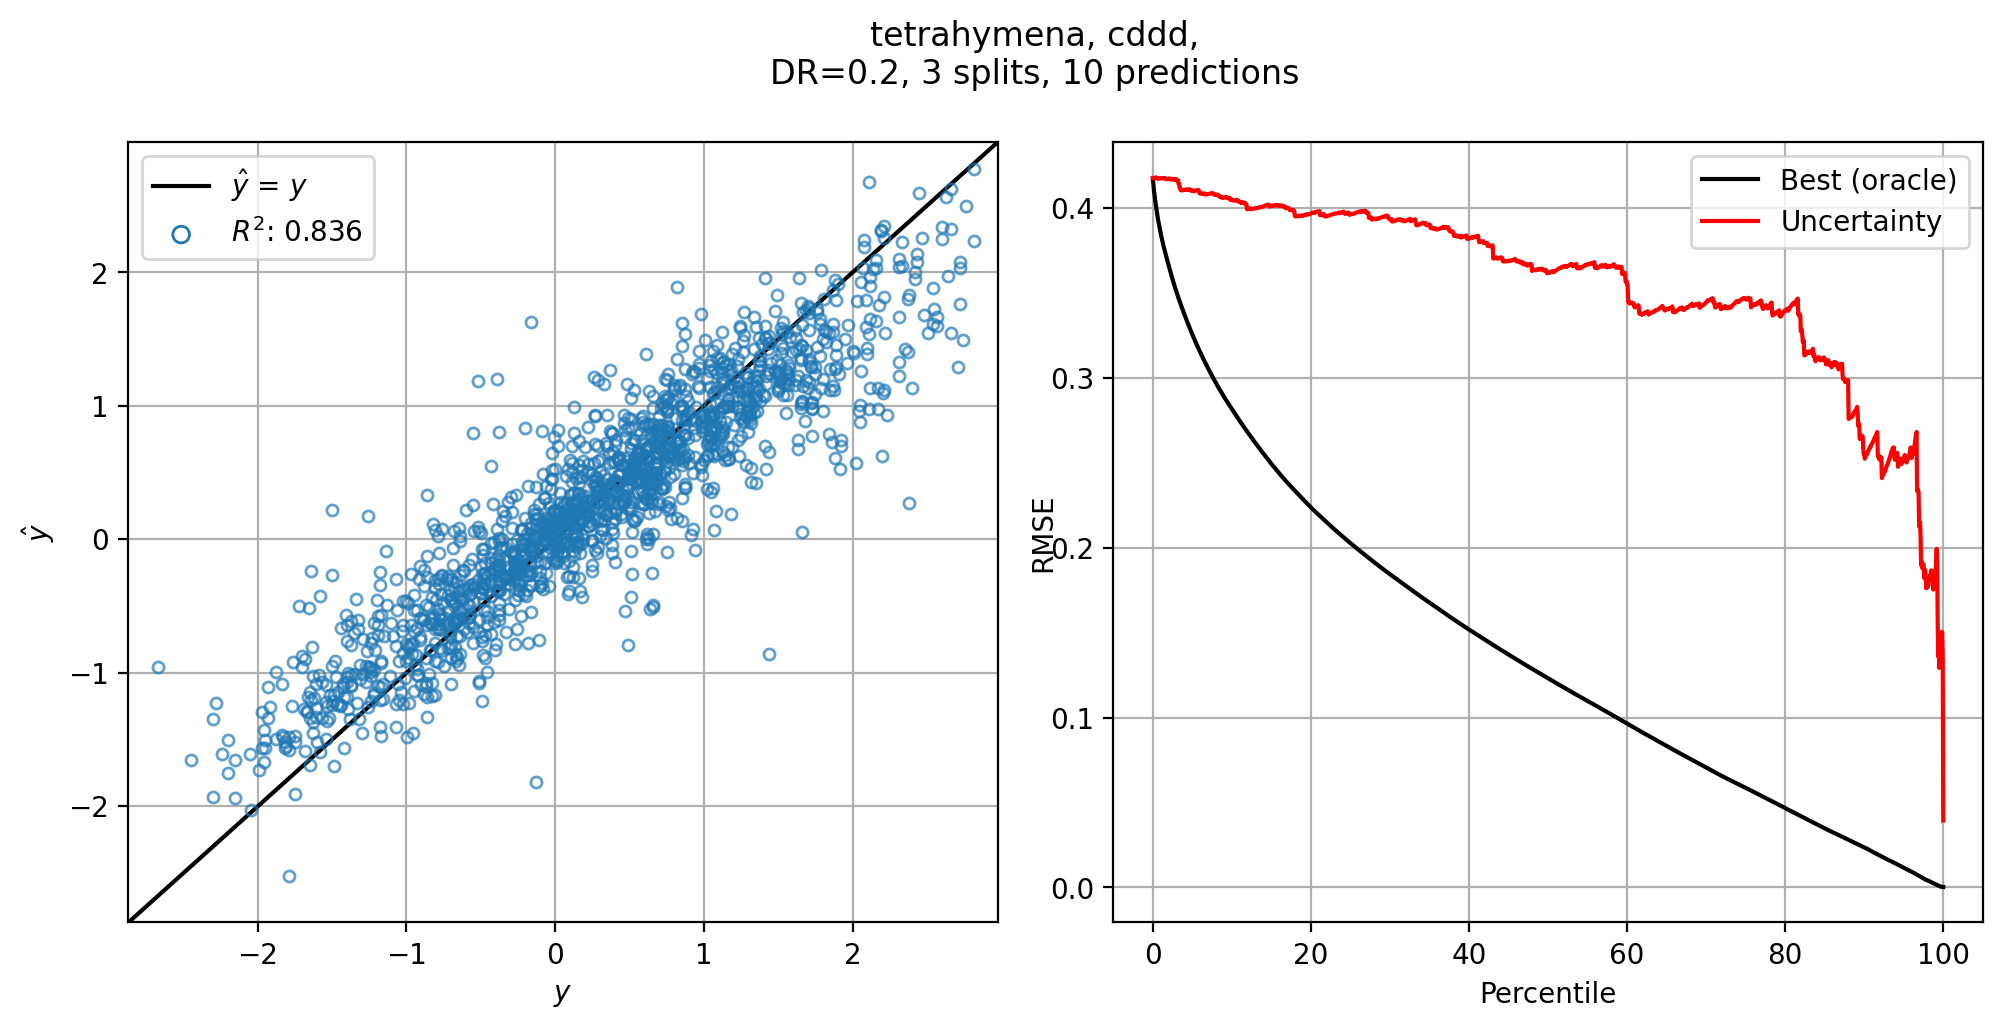

In [5]:
evaluation_automization('tetrahymena', 'cddd', n_preds=10, n_splits=3)

<hr/>

#### Tetrahymena, all descriptors

10it [01:01,  6.18s/it]


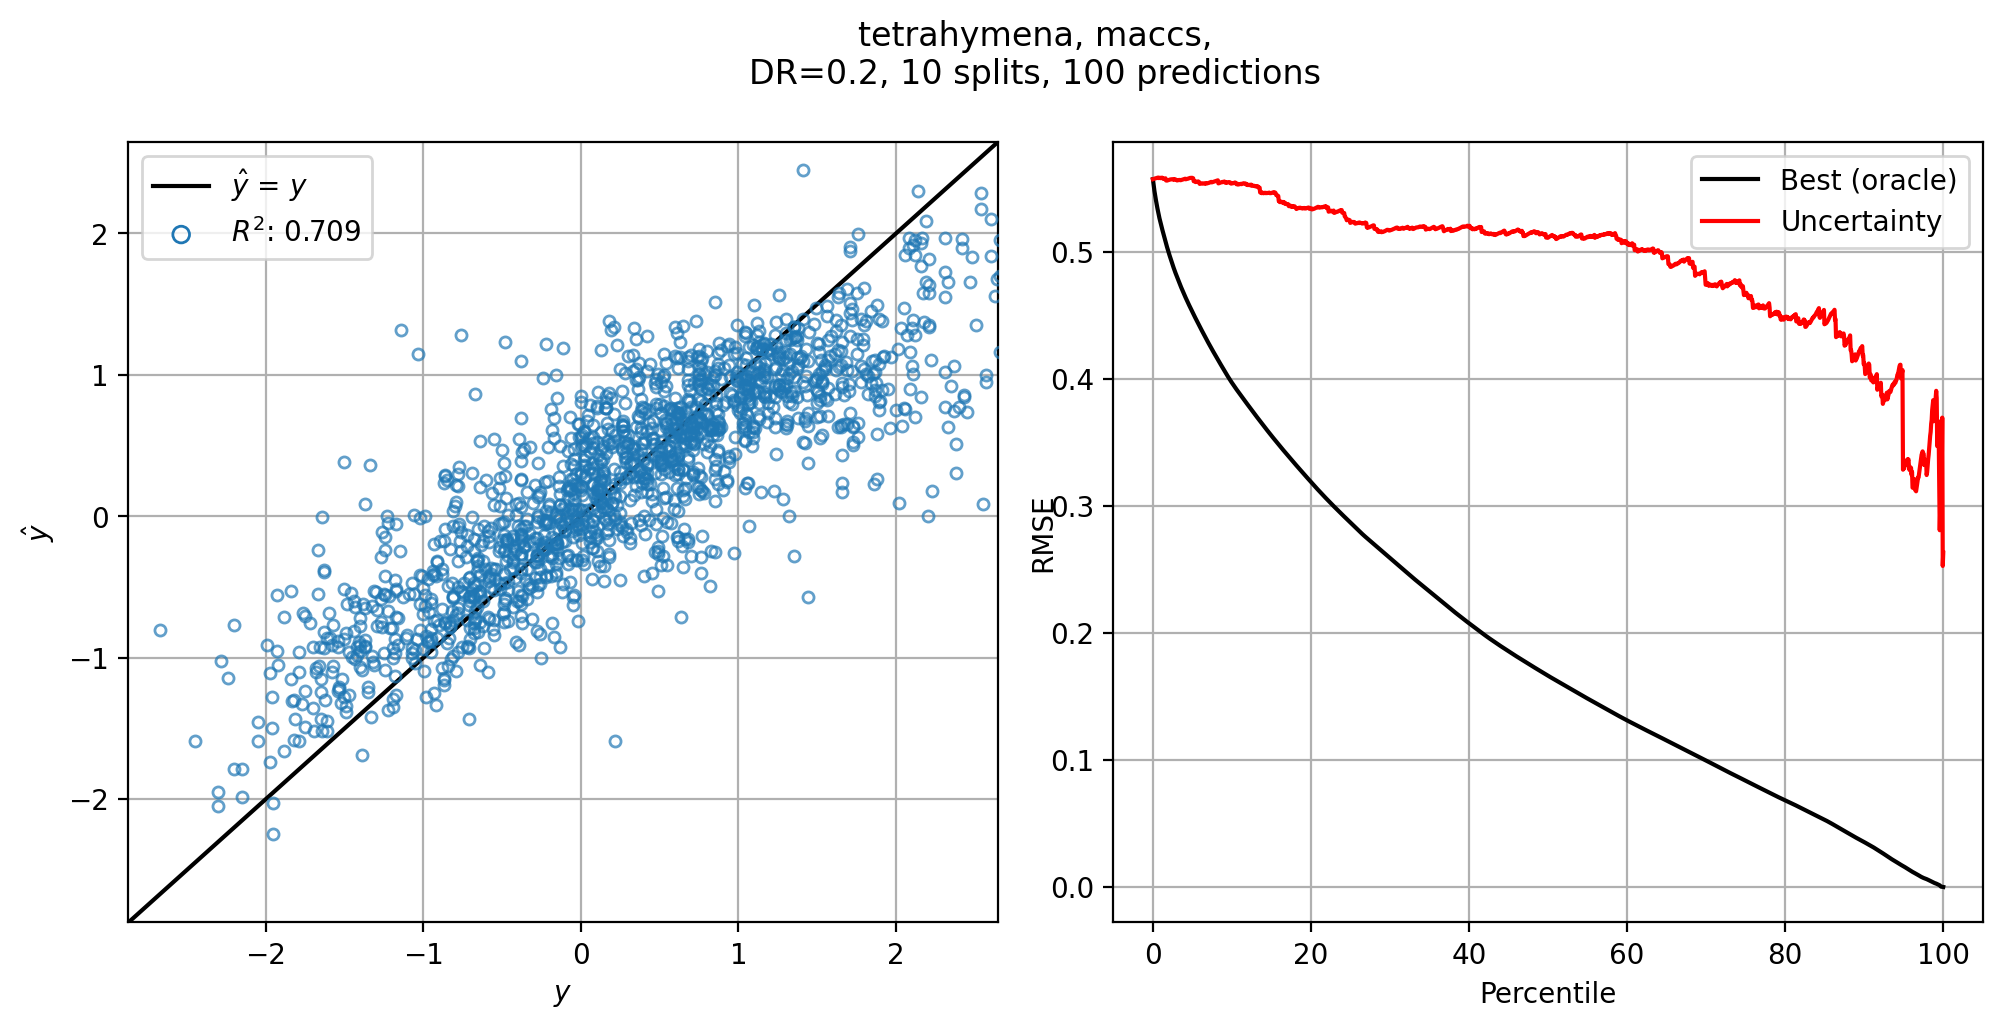

In [6]:
evaluation_automization('tetrahymena', 'maccs', scale=False)

10it [01:06,  6.66s/it]


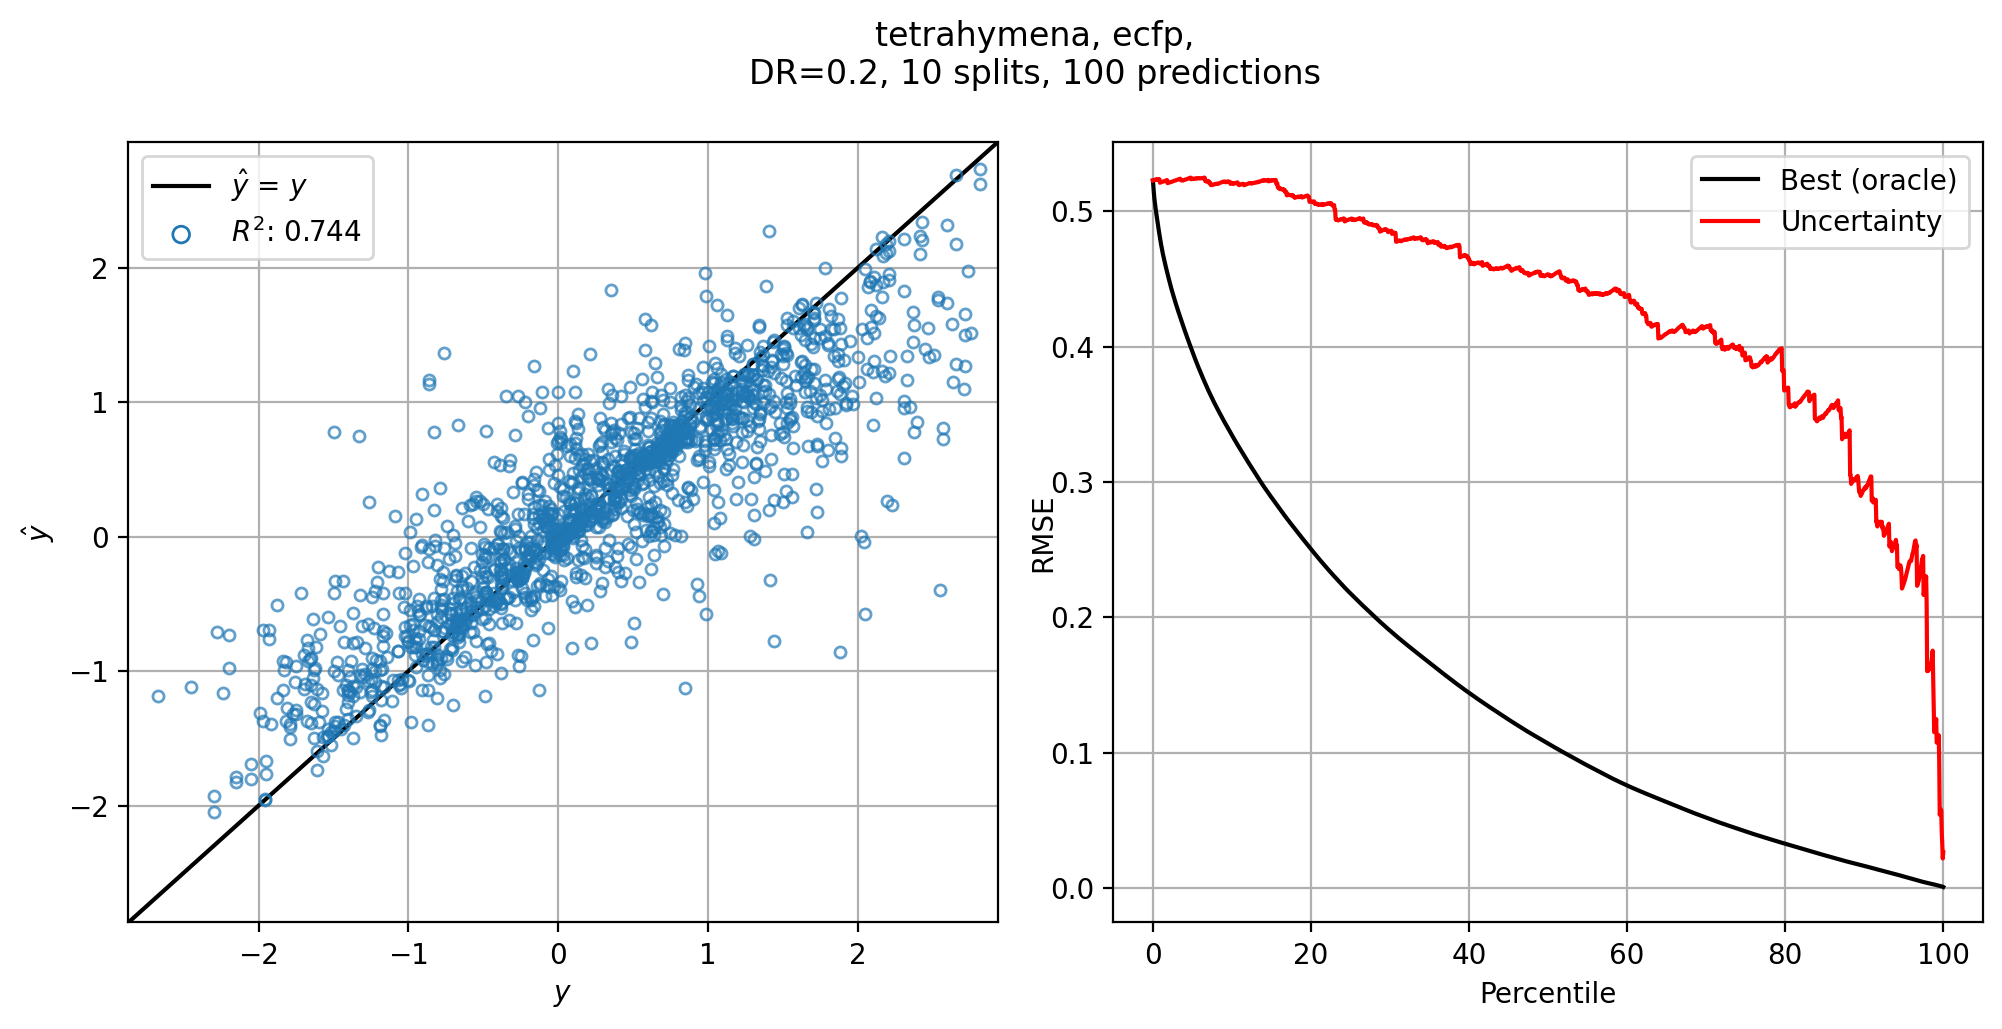

In [7]:
evaluation_automization('tetrahymena', 'ecfp', scale=False)

10it [01:00,  6.02s/it]


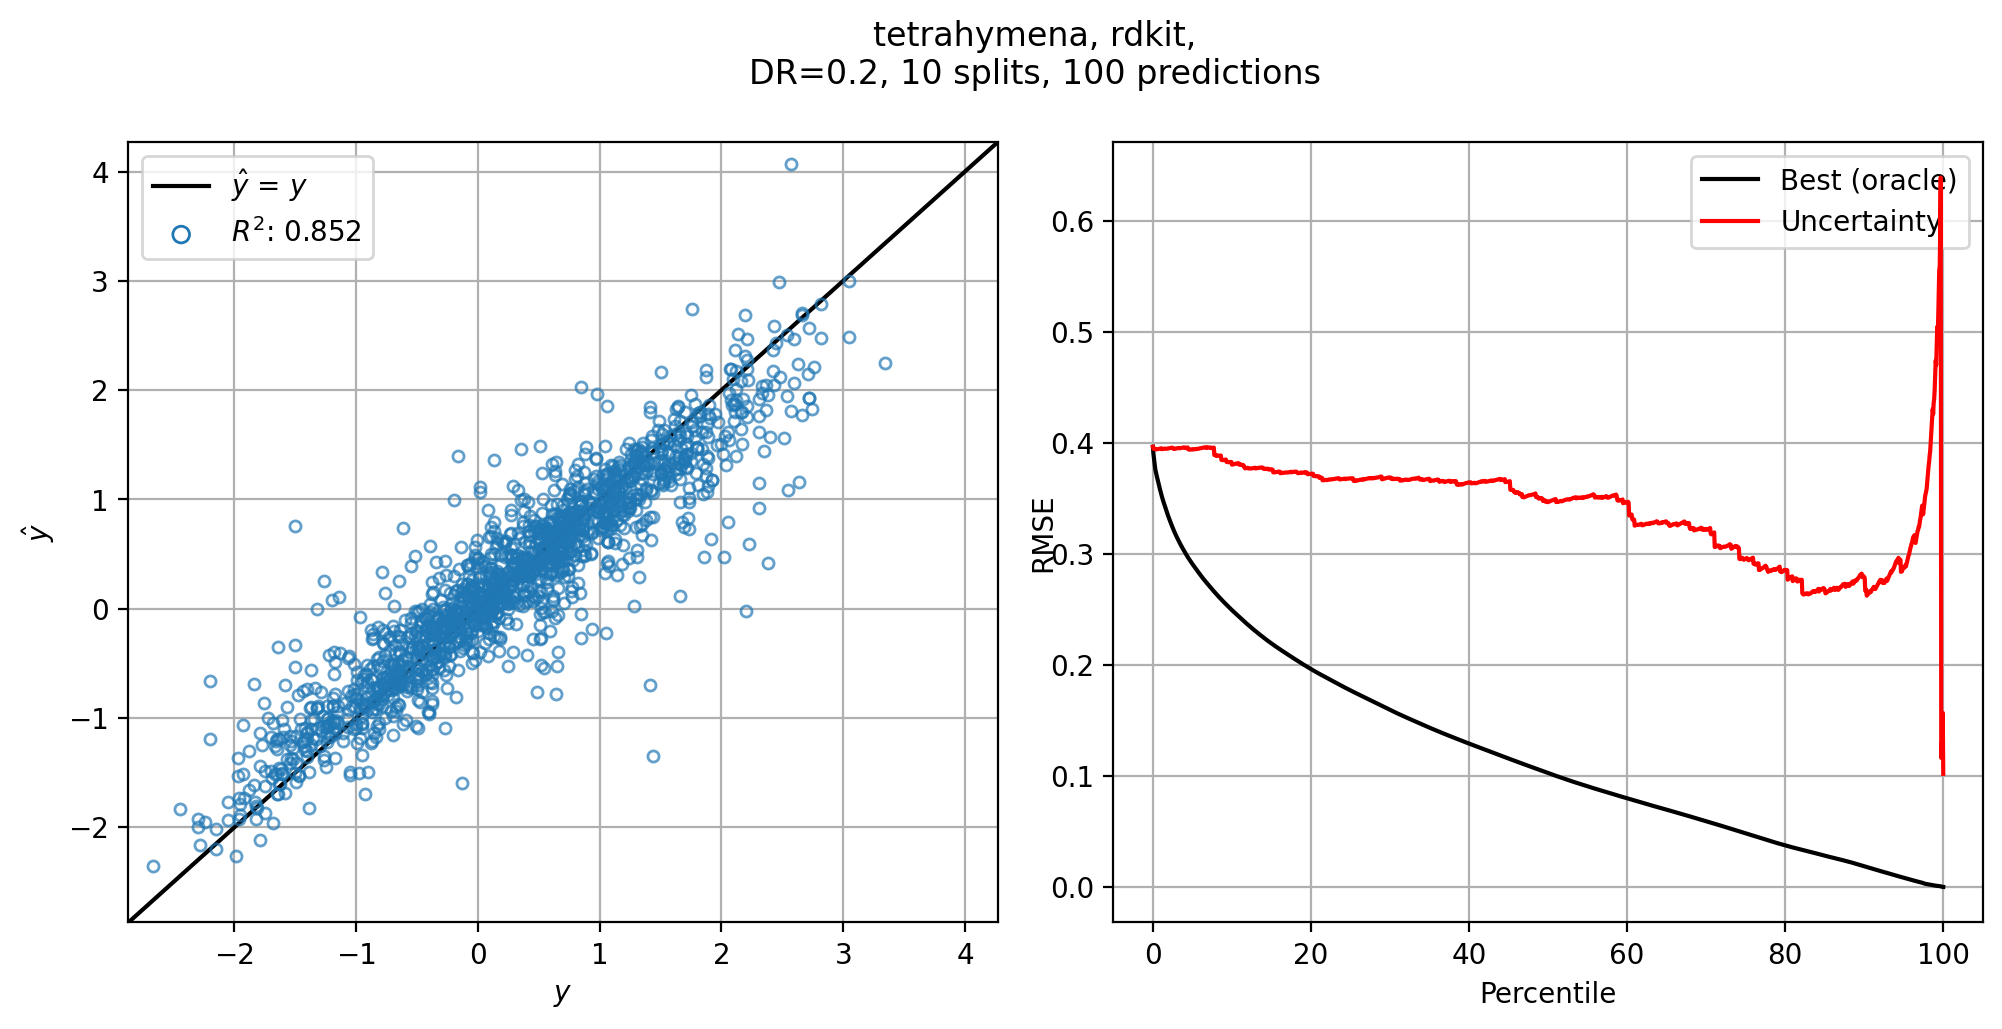

In [8]:
evaluation_automization('tetrahymena', 'rdkit')

10it [01:01,  6.13s/it]


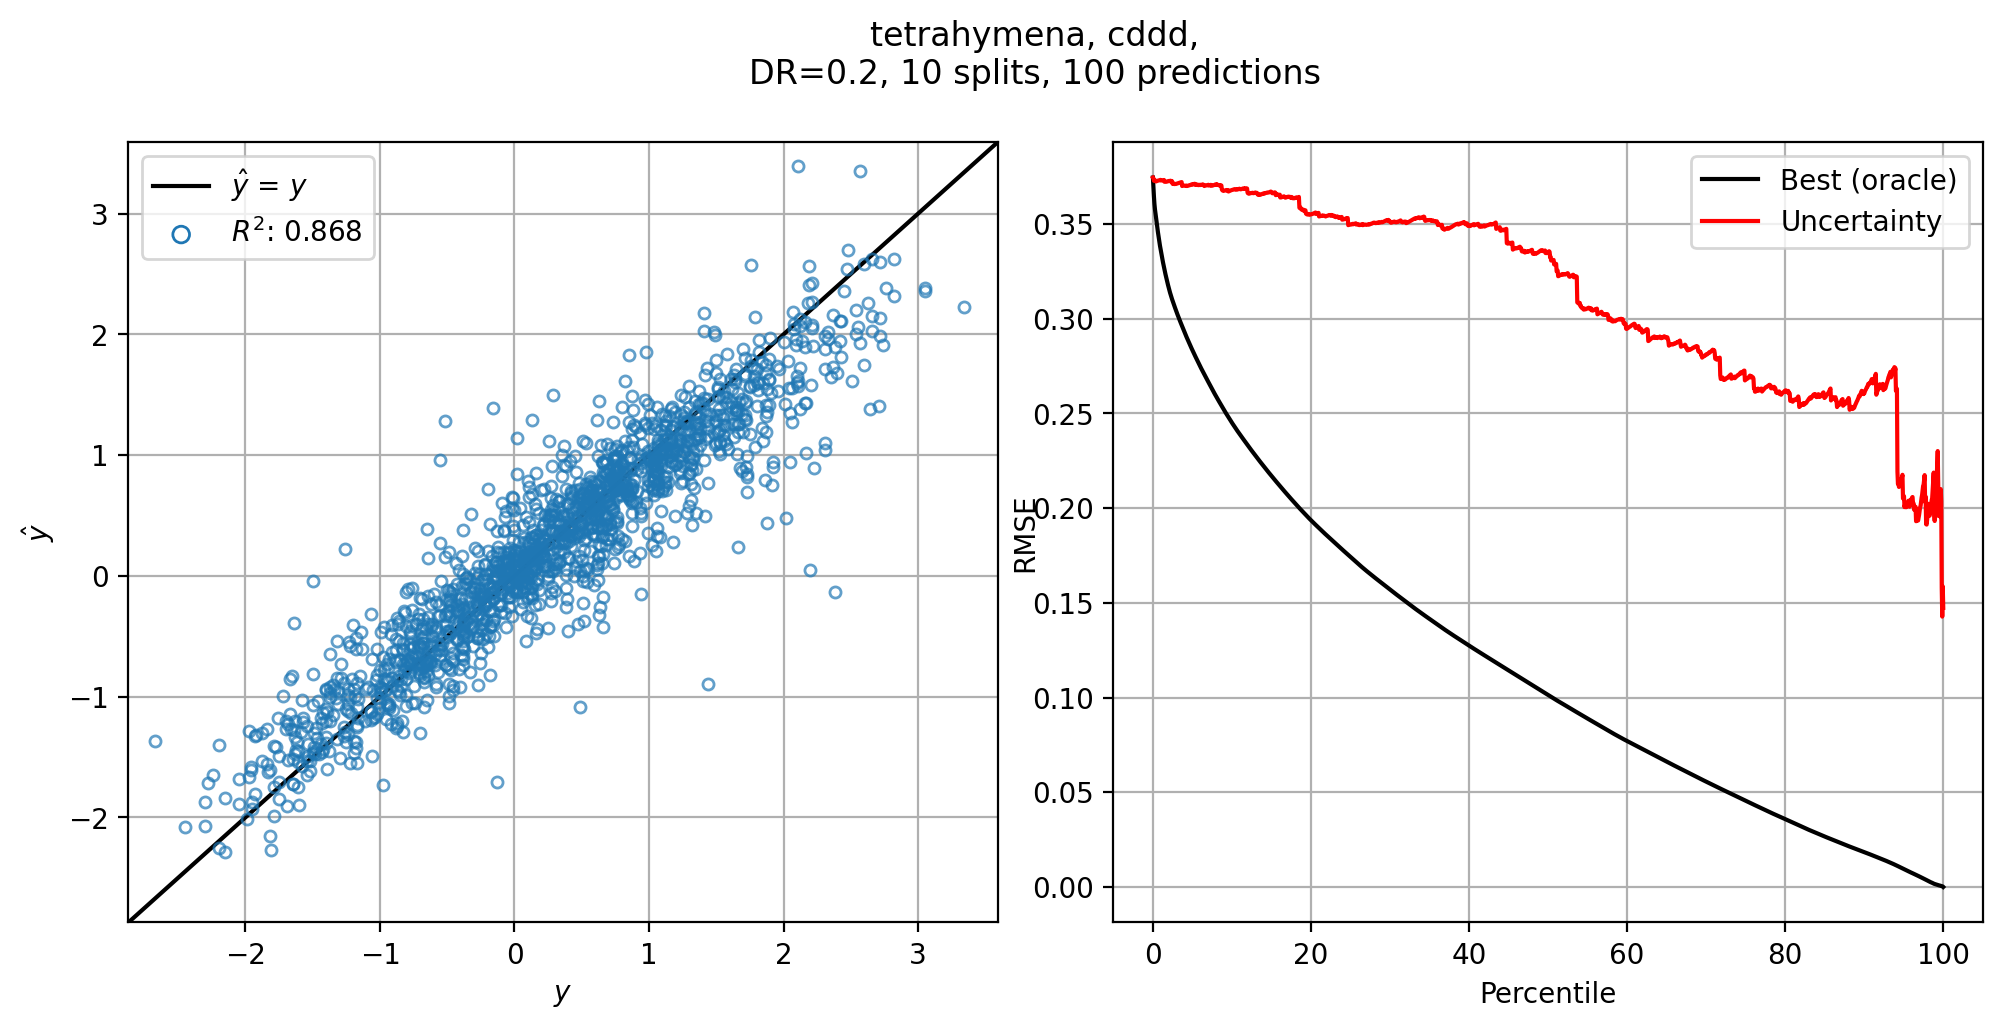

In [9]:
evaluation_automization('tetrahymena', 'cddd')

<hr/>

#### FreeSolv, all descriptors

10it [00:40,  4.10s/it]


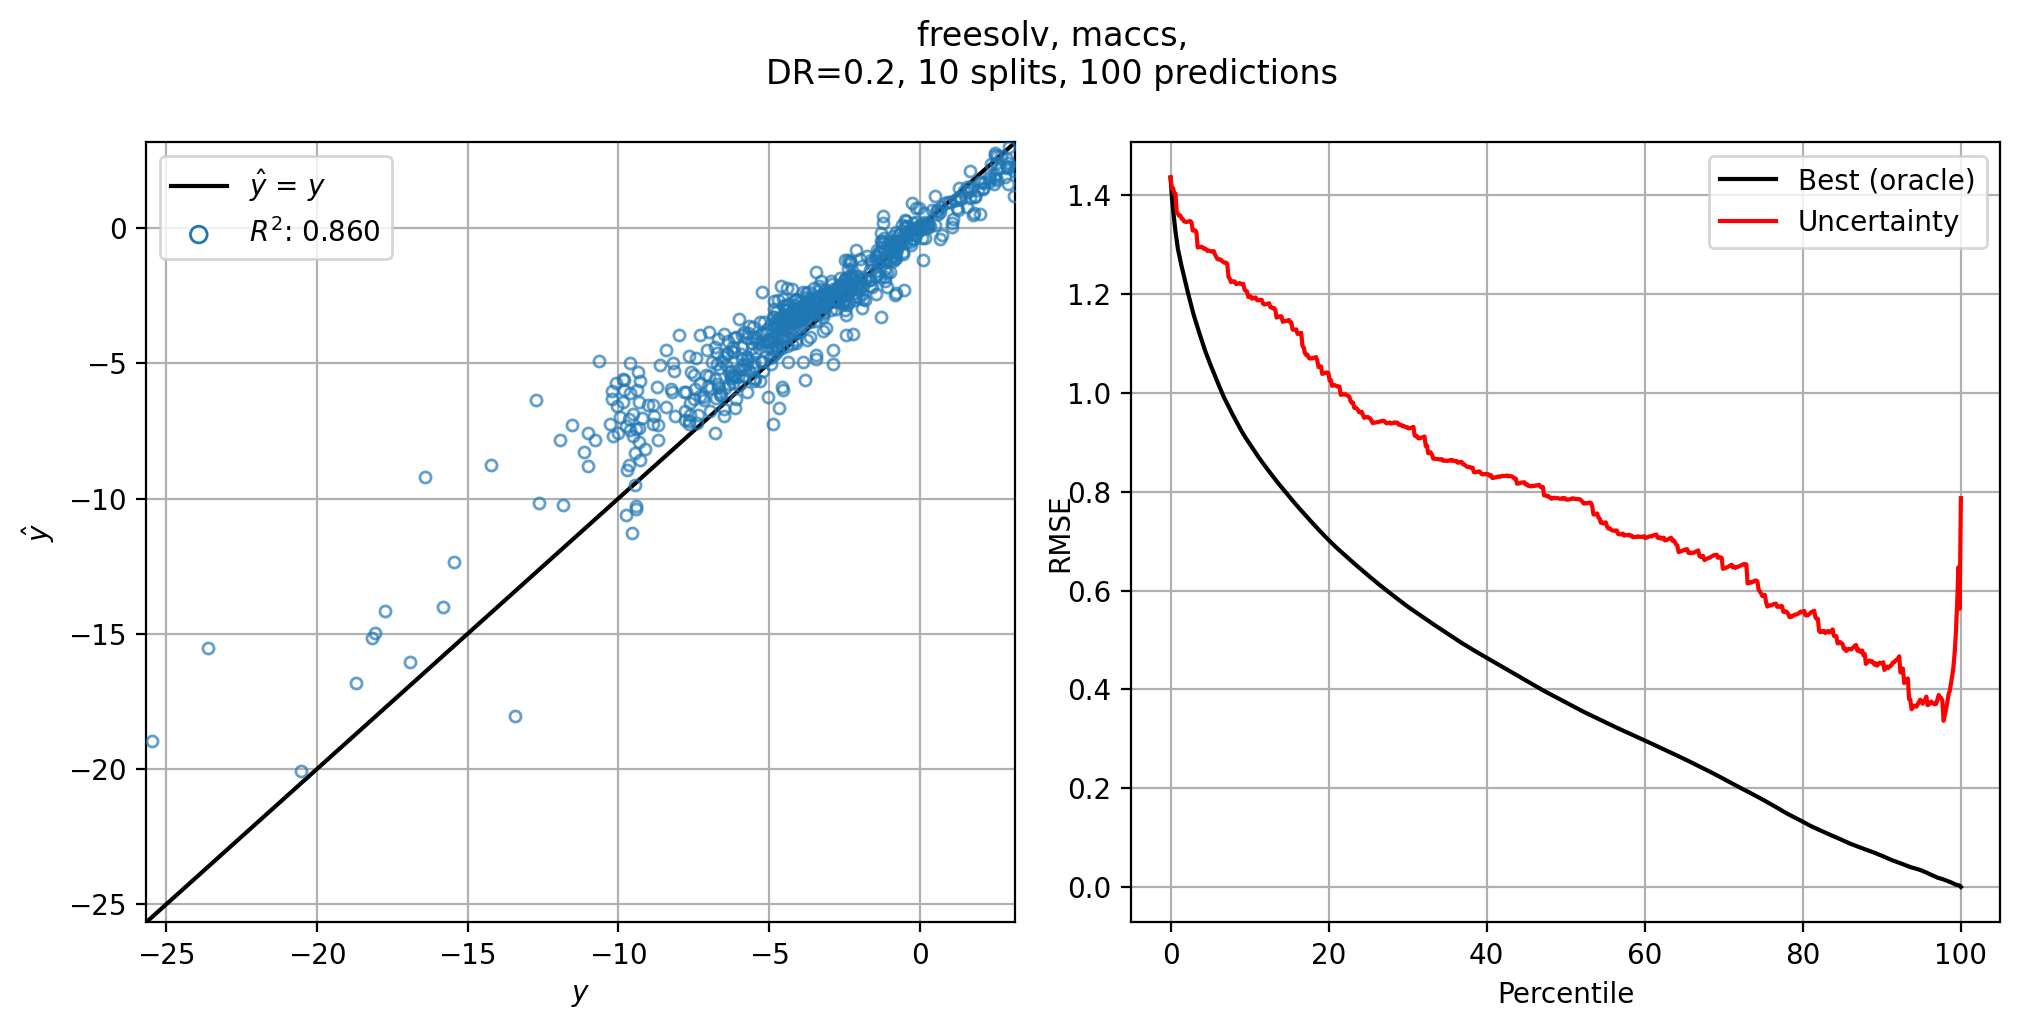

In [10]:
evaluation_automization('freesolv', 'maccs', scale=False)

10it [00:42,  4.28s/it]


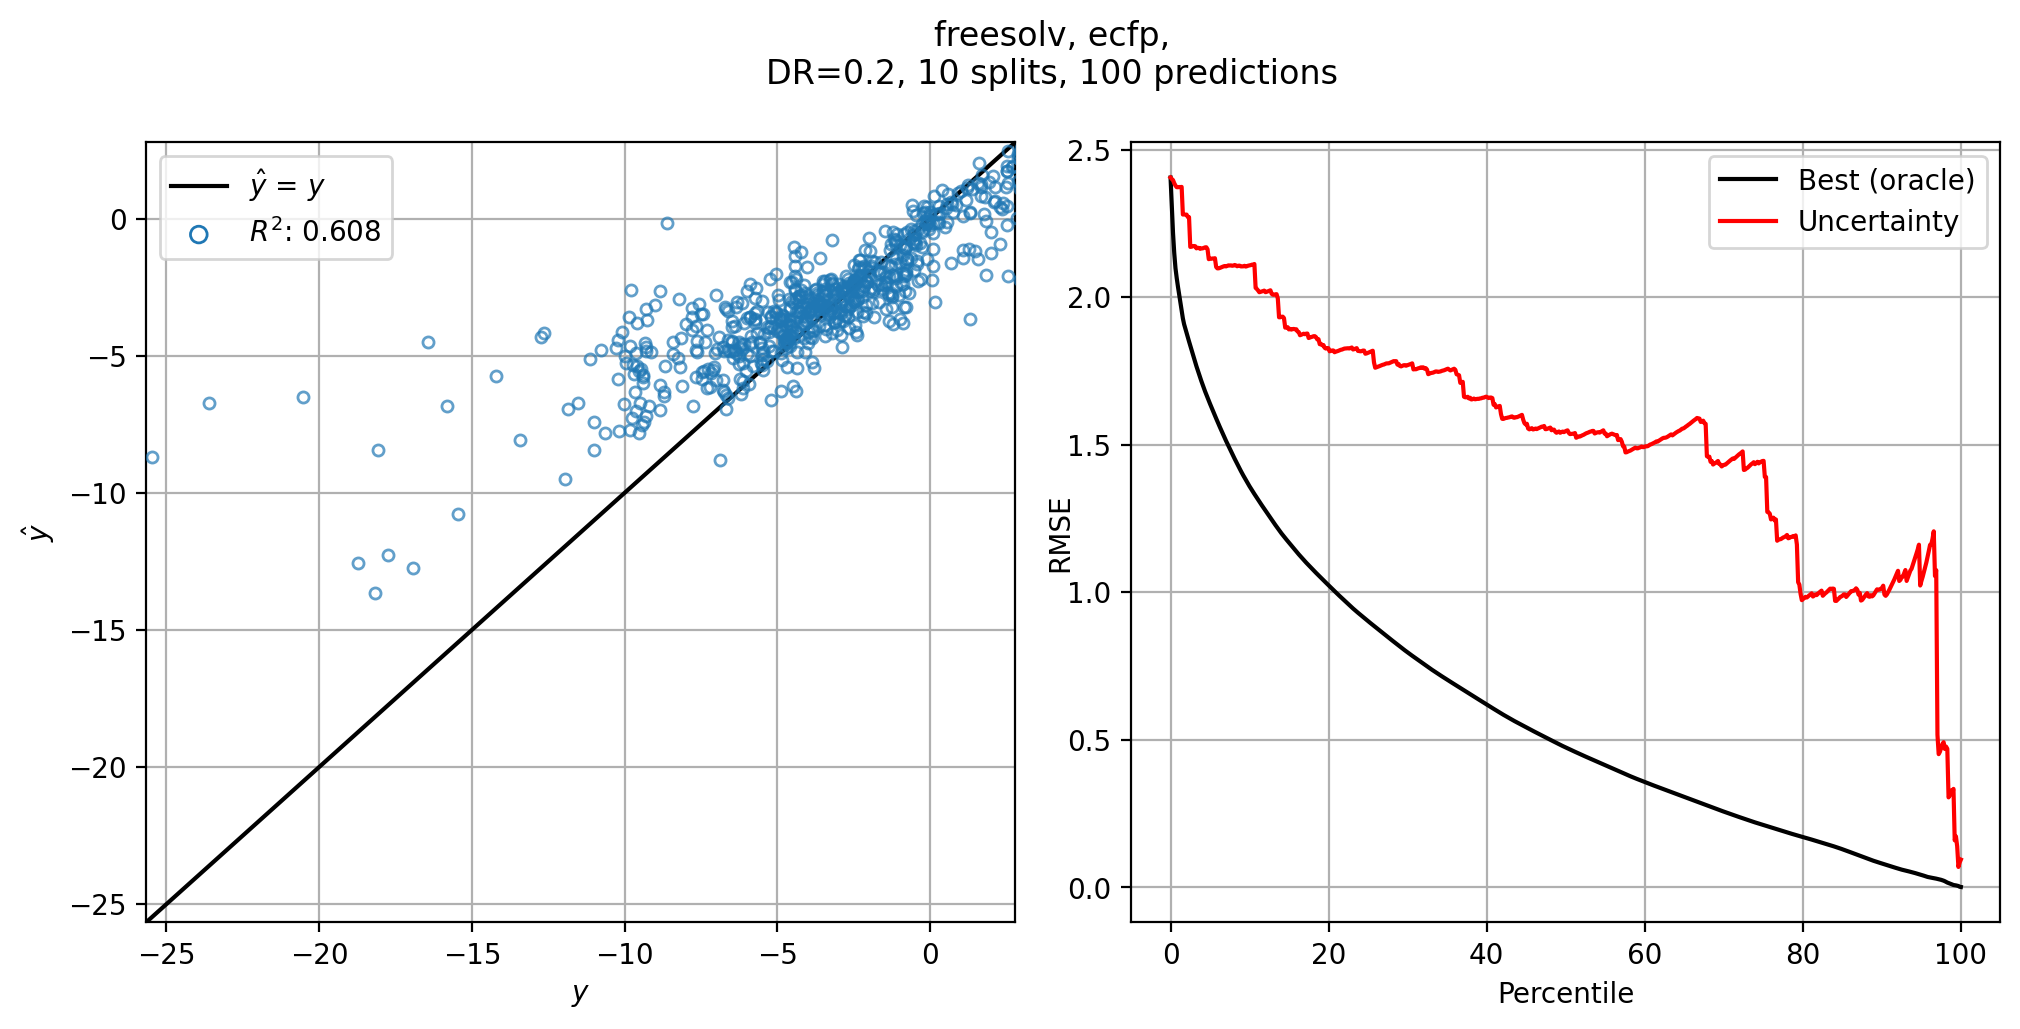

In [11]:
evaluation_automization('freesolv', 'ecfp', scale=False)

10it [00:38,  3.84s/it]


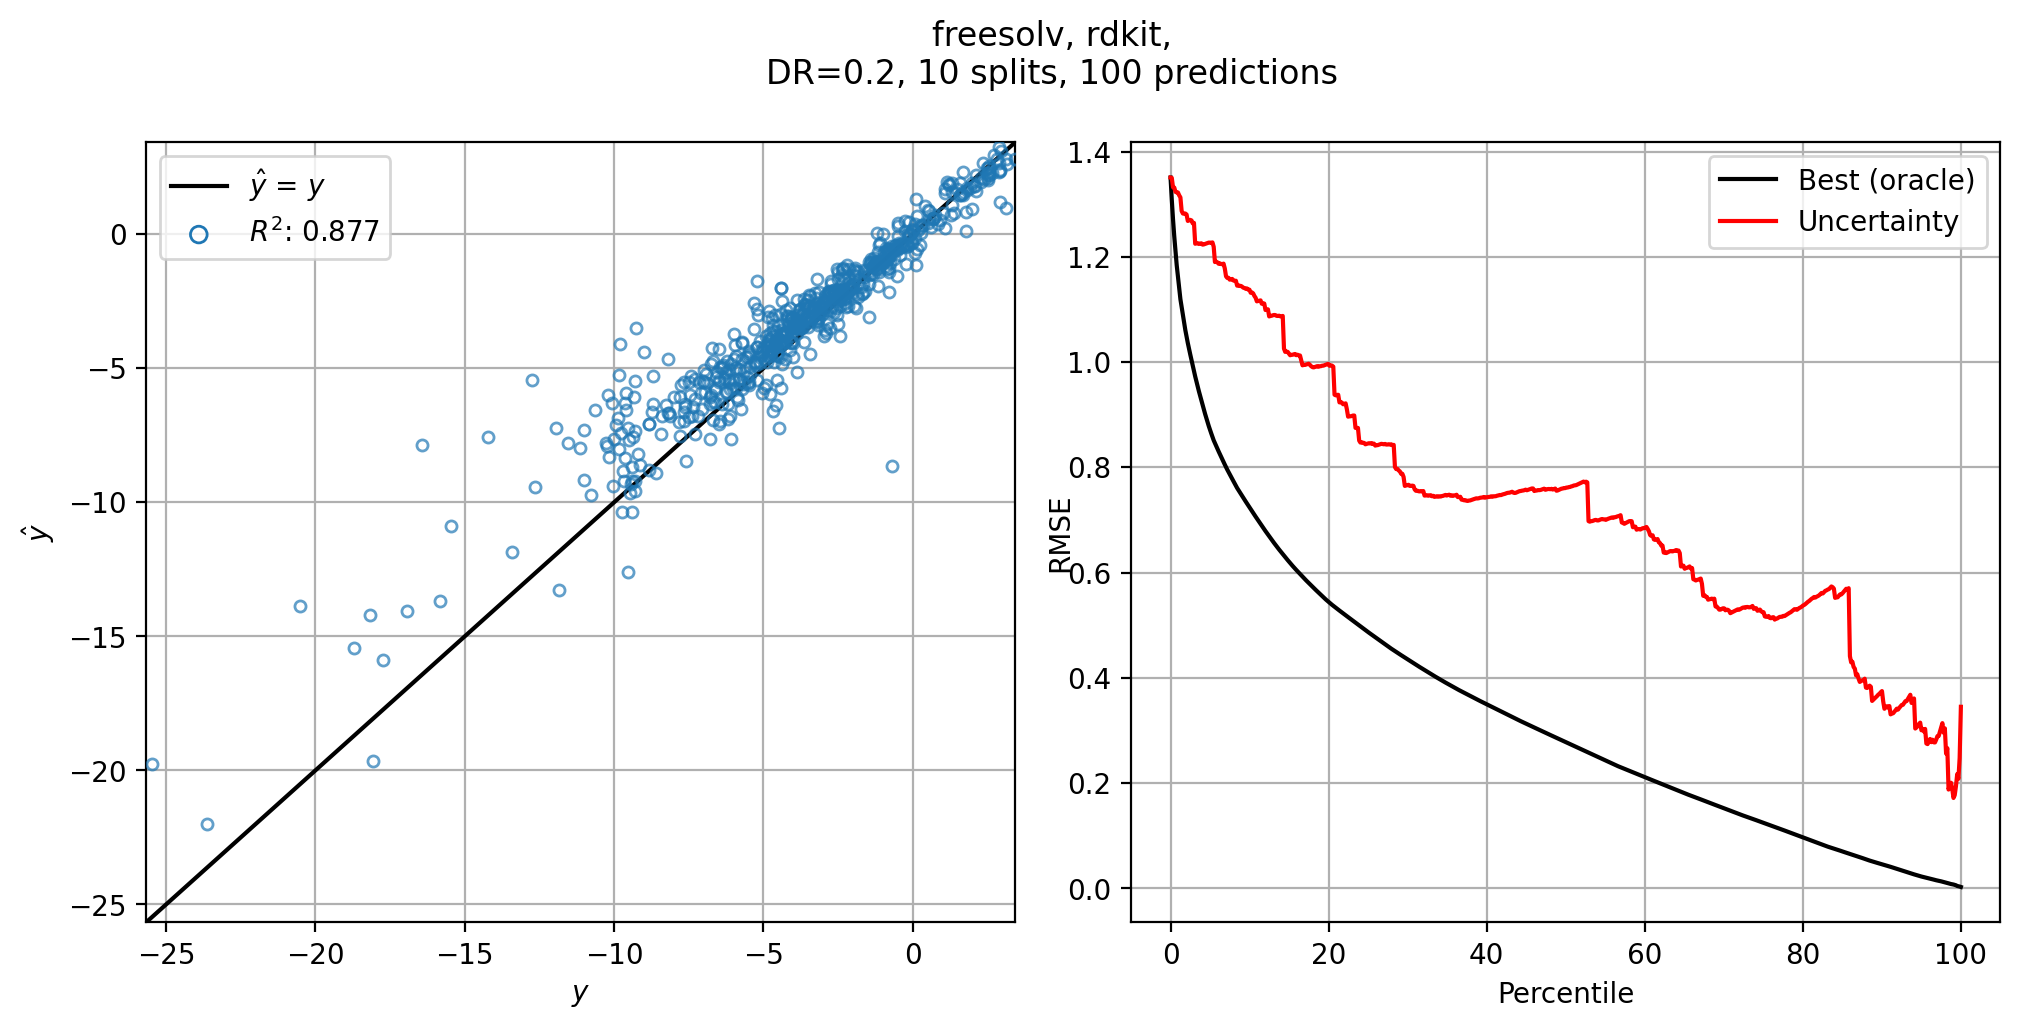

In [12]:
evaluation_automization('freesolv', 'rdkit')

10it [00:39,  4.00s/it]


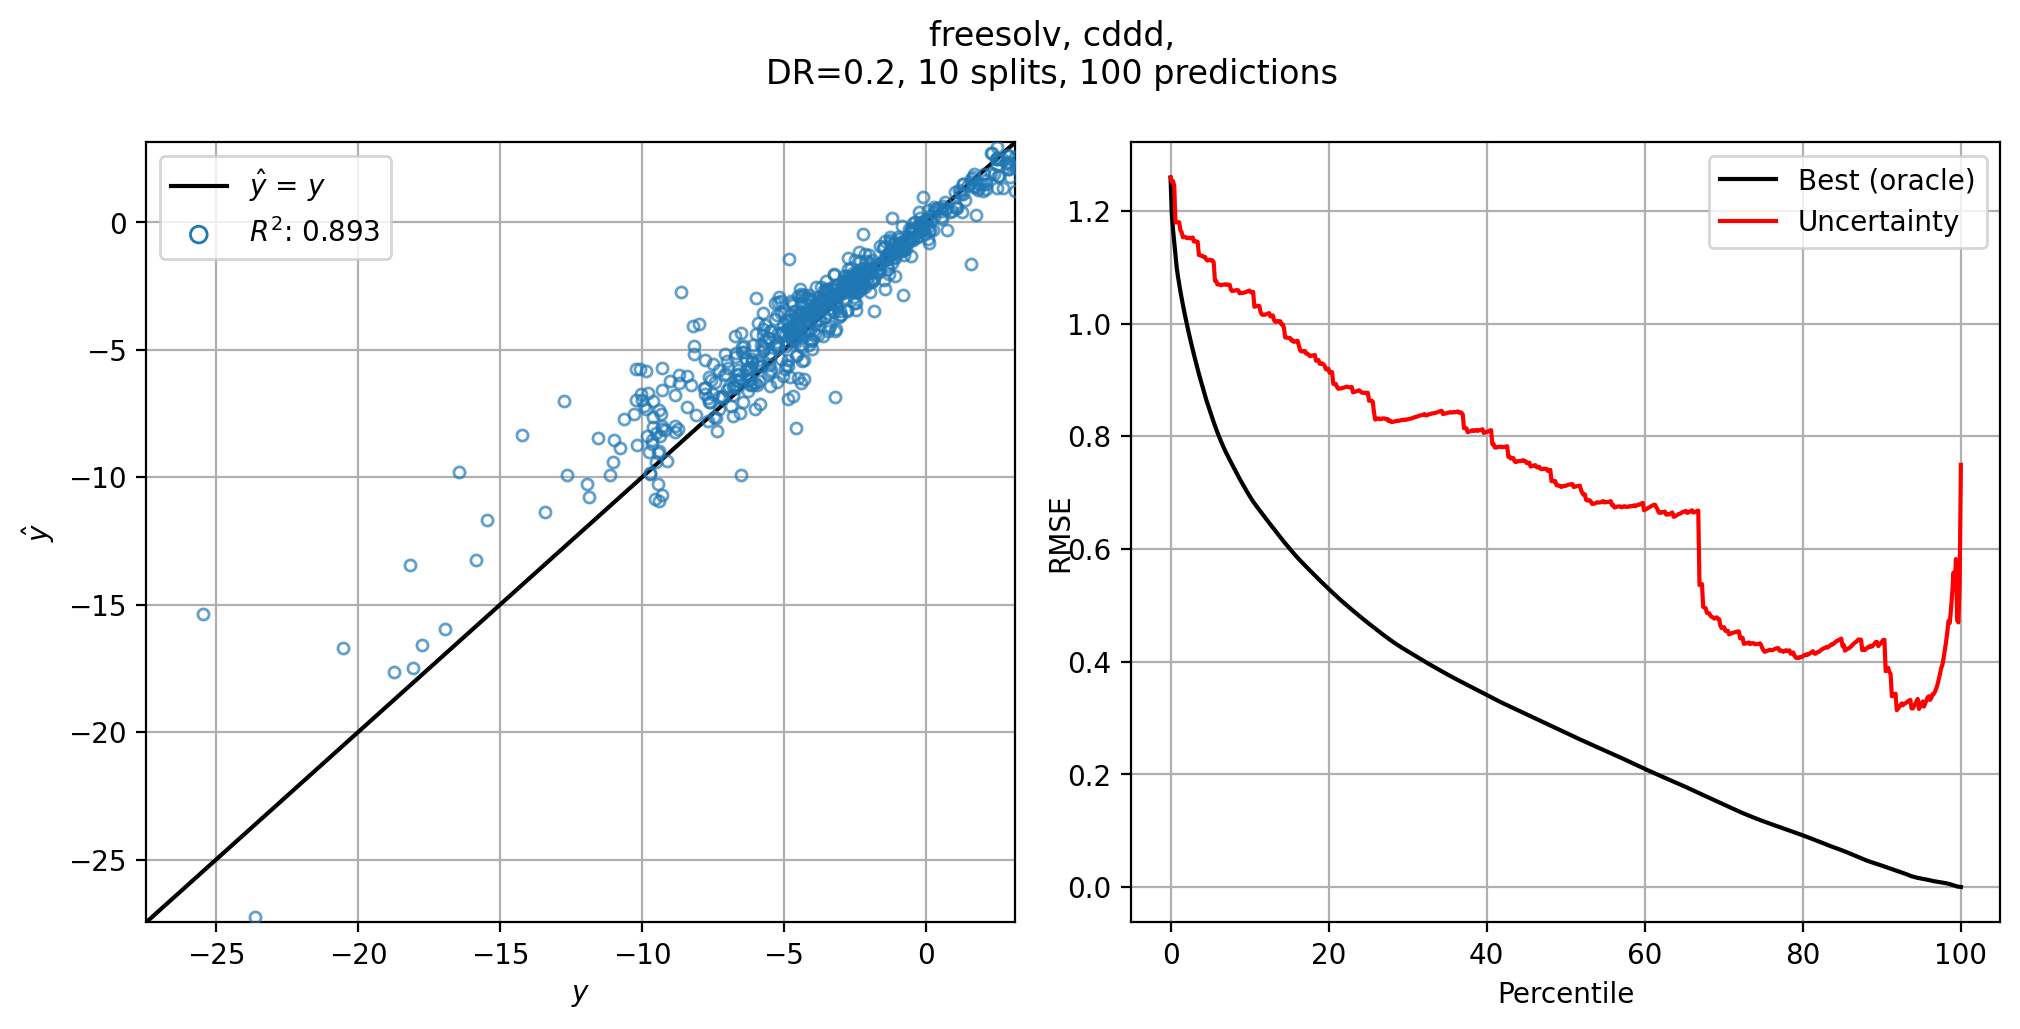

In [13]:
evaluation_automization('freesolv', 'cddd')

<hr/>

#### ESOL, all descriptors

10it [00:52,  5.25s/it]


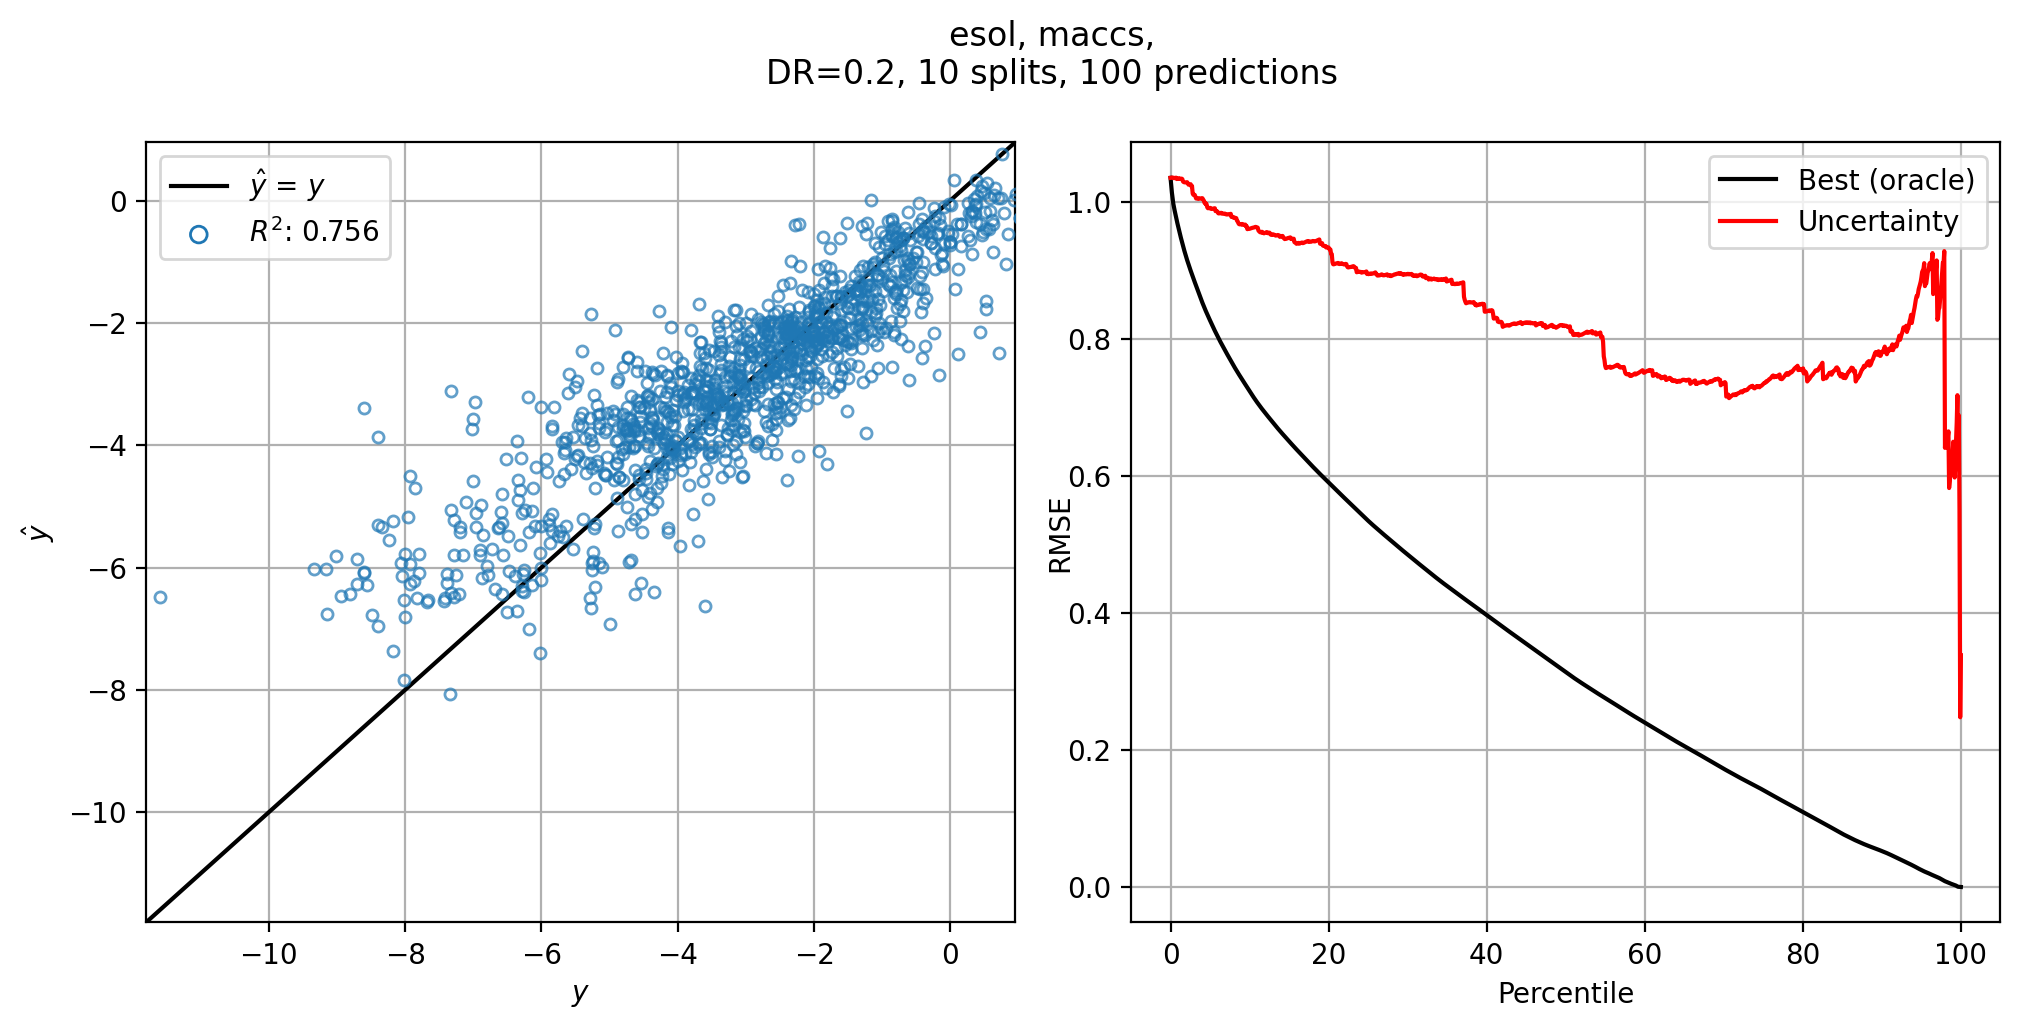

In [14]:
evaluation_automization('esol', 'maccs', scale=False)

10it [00:56,  5.67s/it]


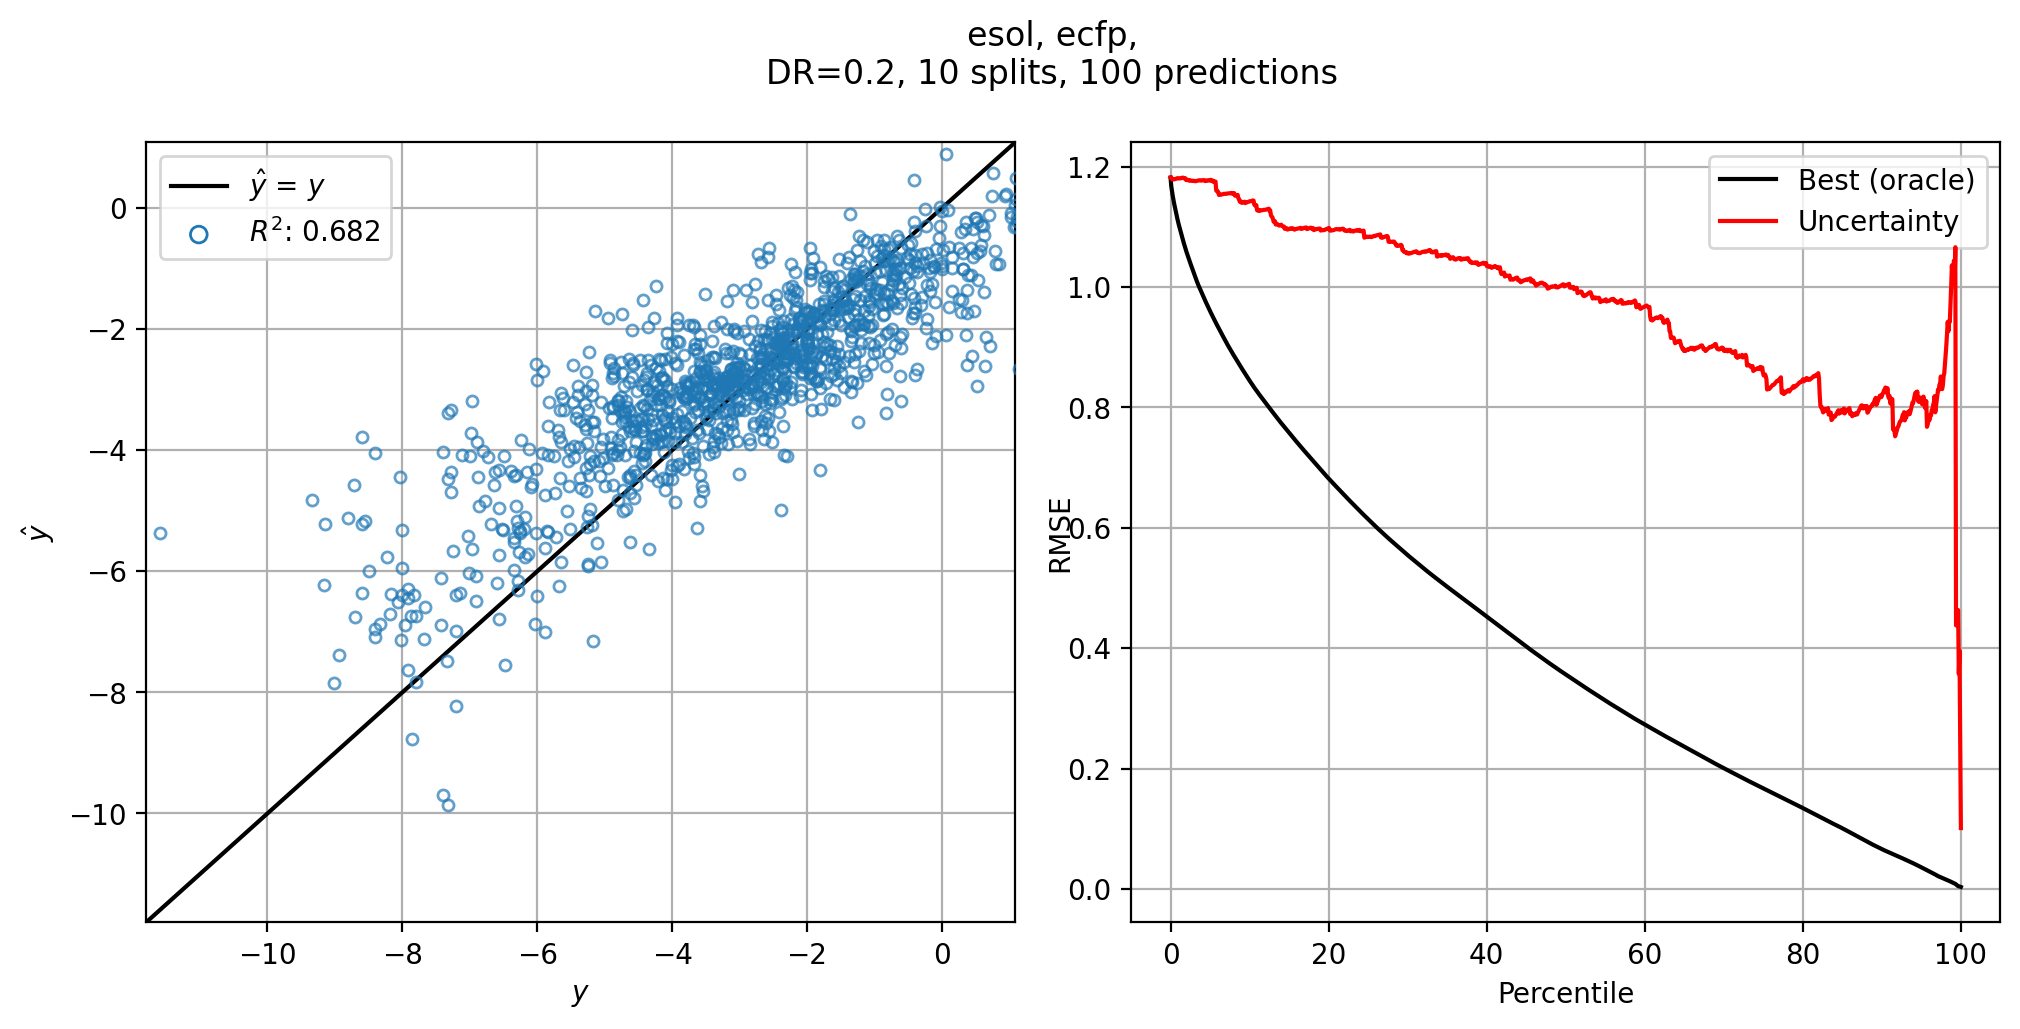

In [15]:
evaluation_automization('esol', 'ecfp', scale=False)

10it [00:50,  5.06s/it]


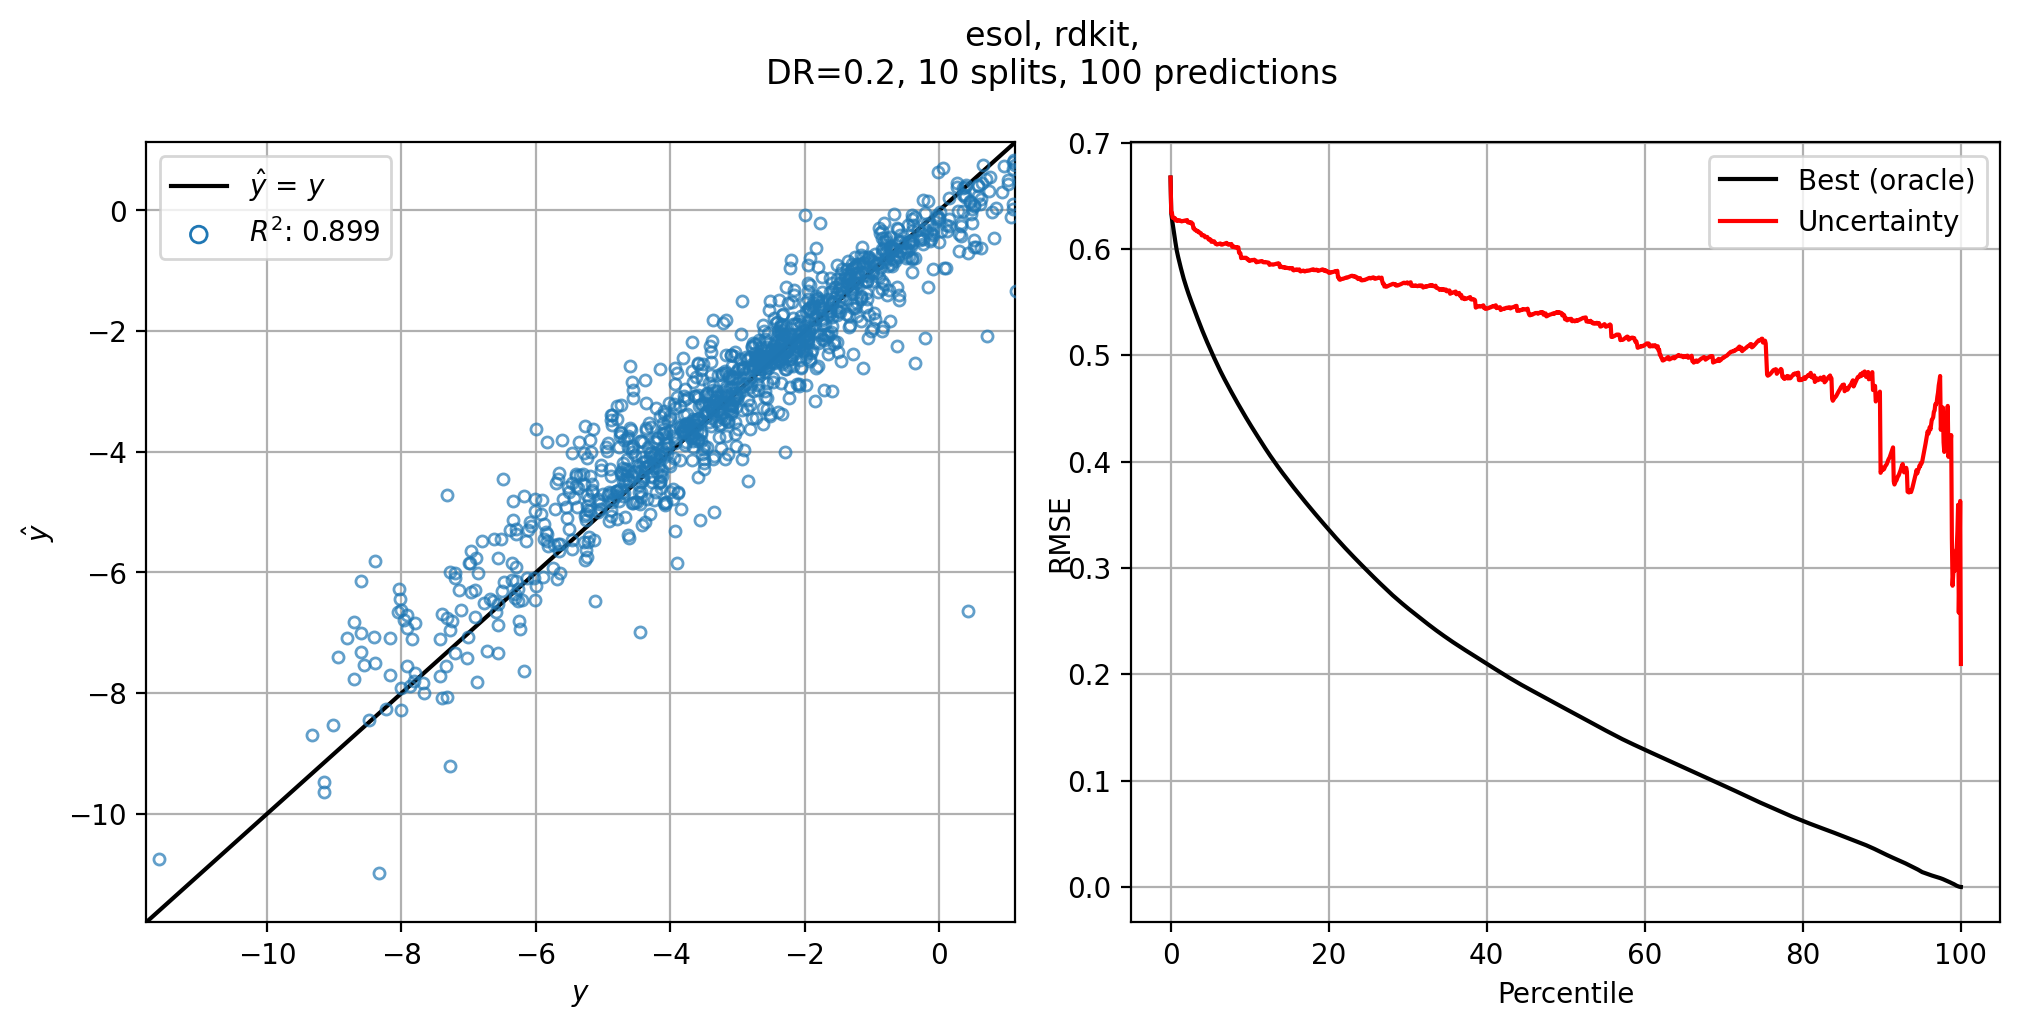

In [16]:
evaluation_automization('esol', 'rdkit')

10it [00:51,  5.16s/it]


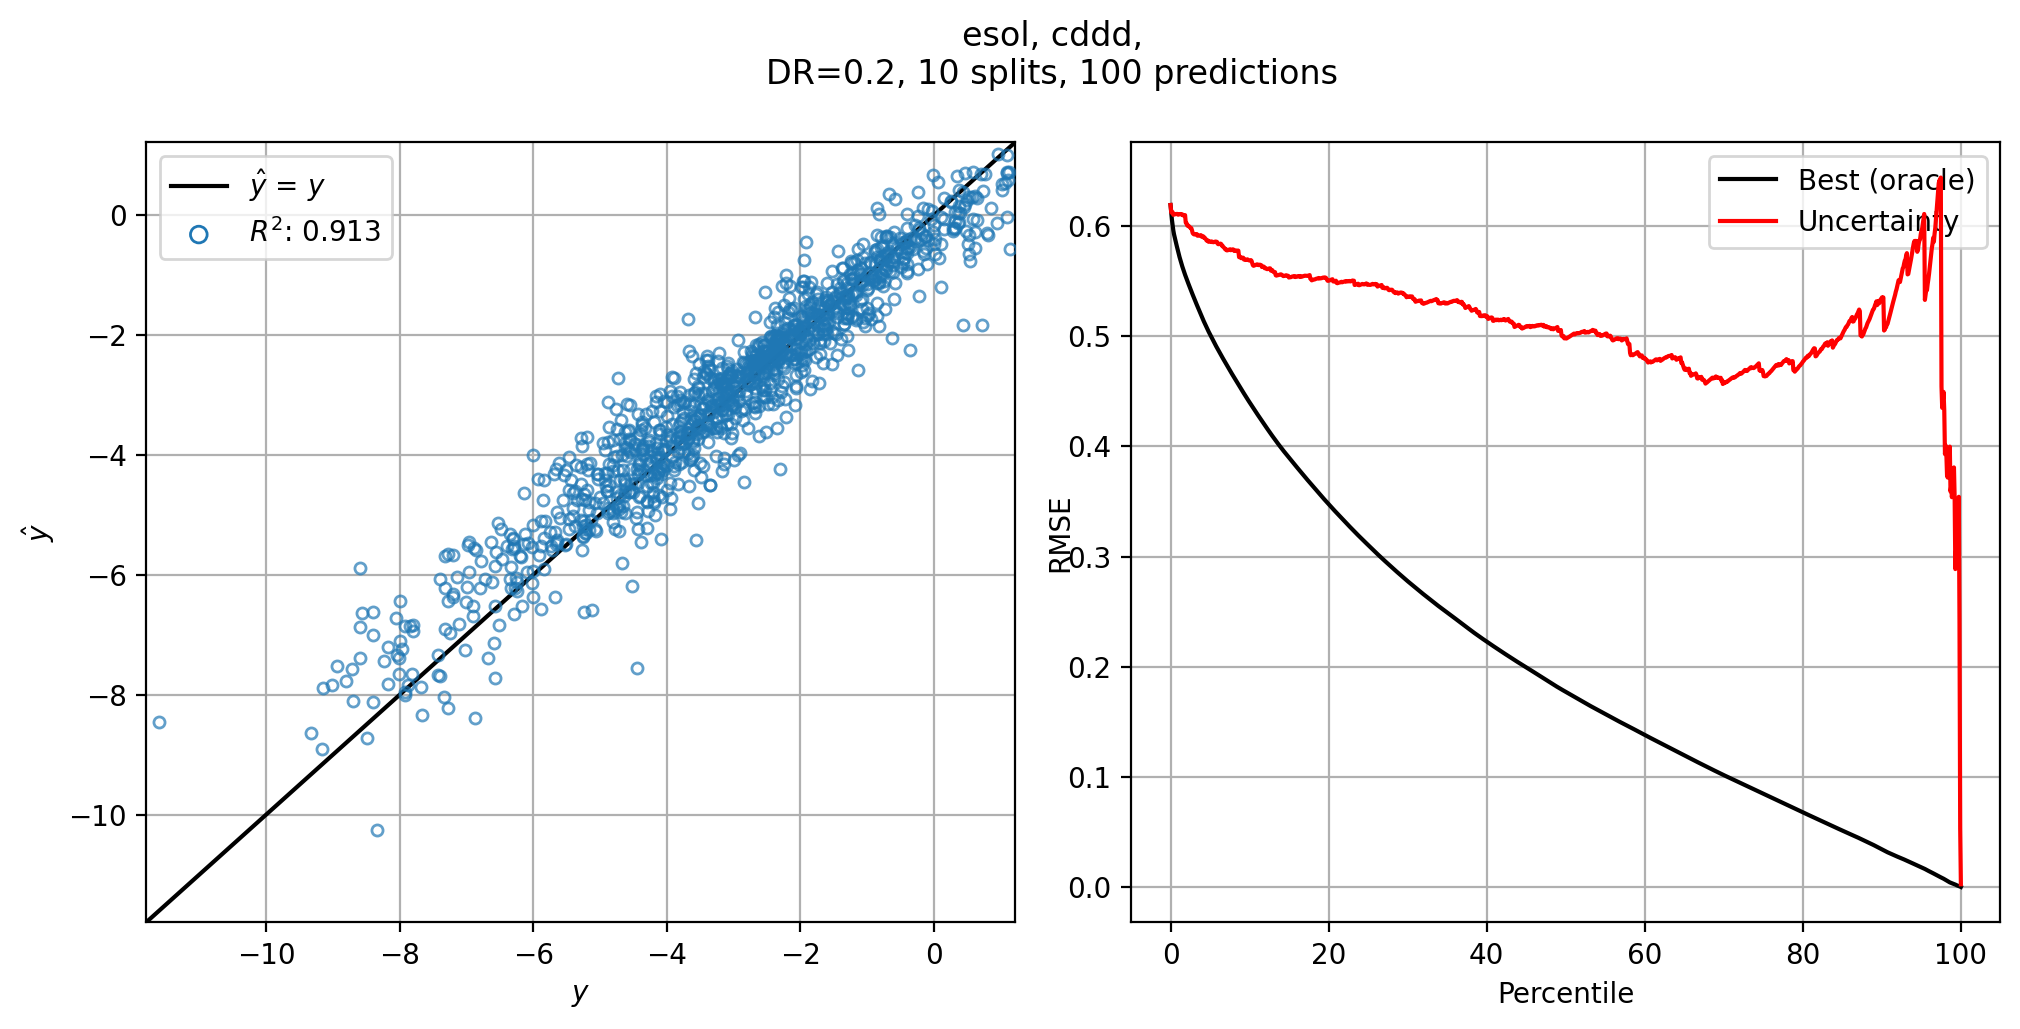

In [17]:
evaluation_automization('esol', 'cddd')

<hr/>

#### IL4, all descriptors

10it [00:40,  4.09s/it]


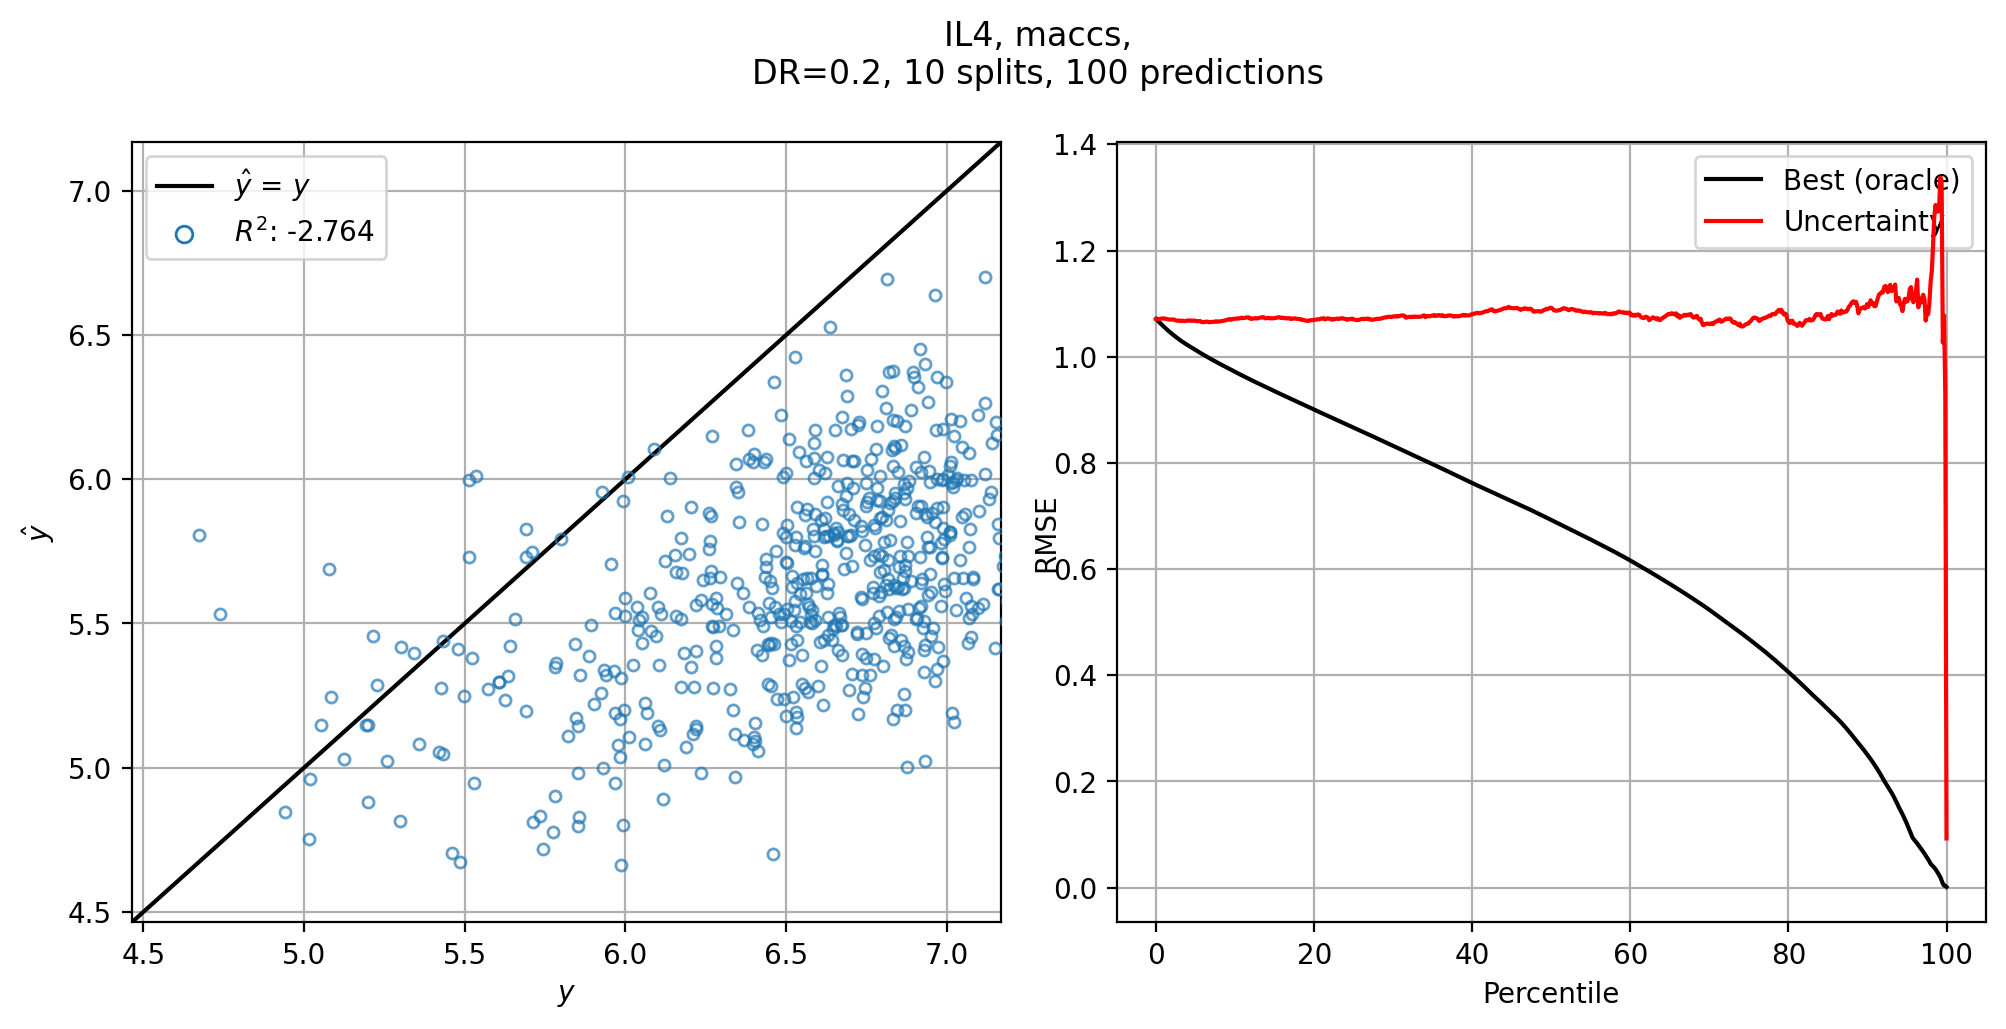

In [18]:
evaluation_automization('IL4', 'maccs', scale=False)

10it [00:43,  4.33s/it]


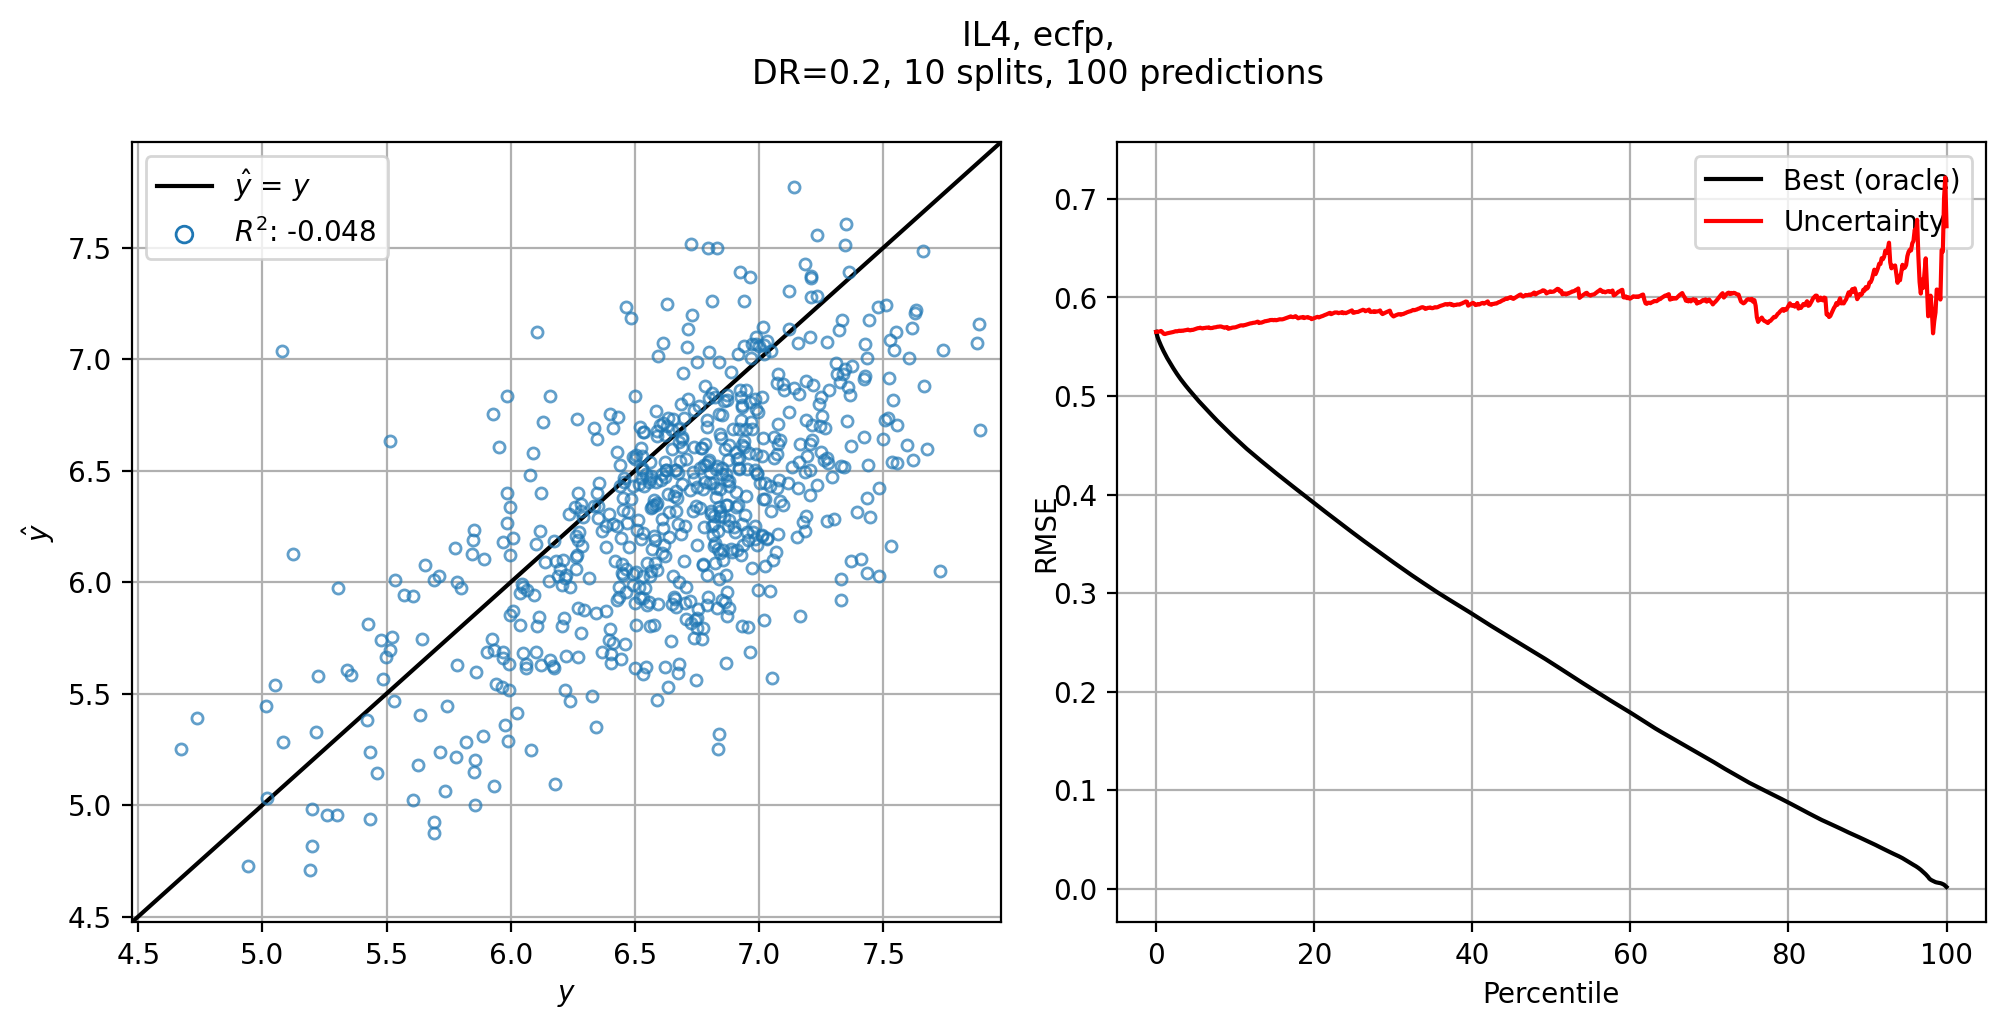

In [19]:
evaluation_automization('IL4', 'ecfp', scale=False)

10it [00:39,  3.94s/it]


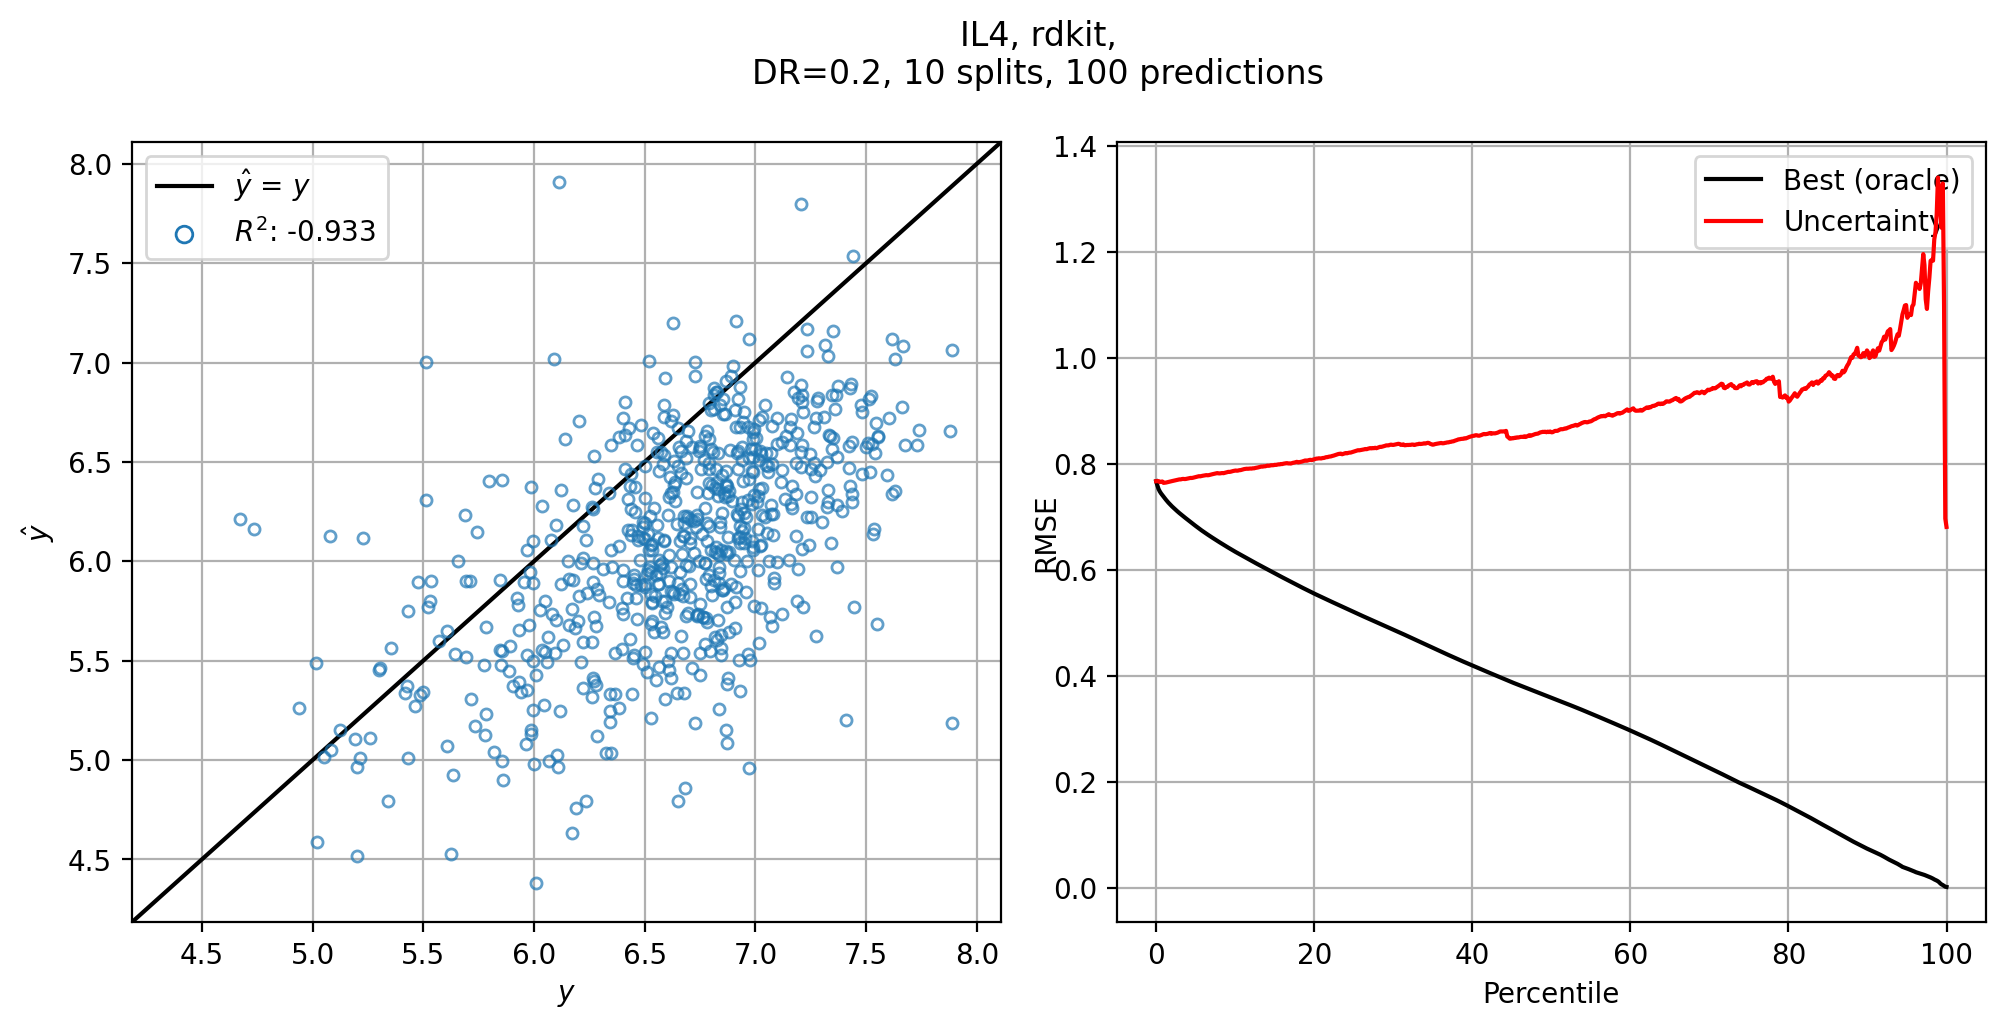

In [20]:
evaluation_automization('IL4', 'rdkit')

10it [00:39,  3.94s/it]


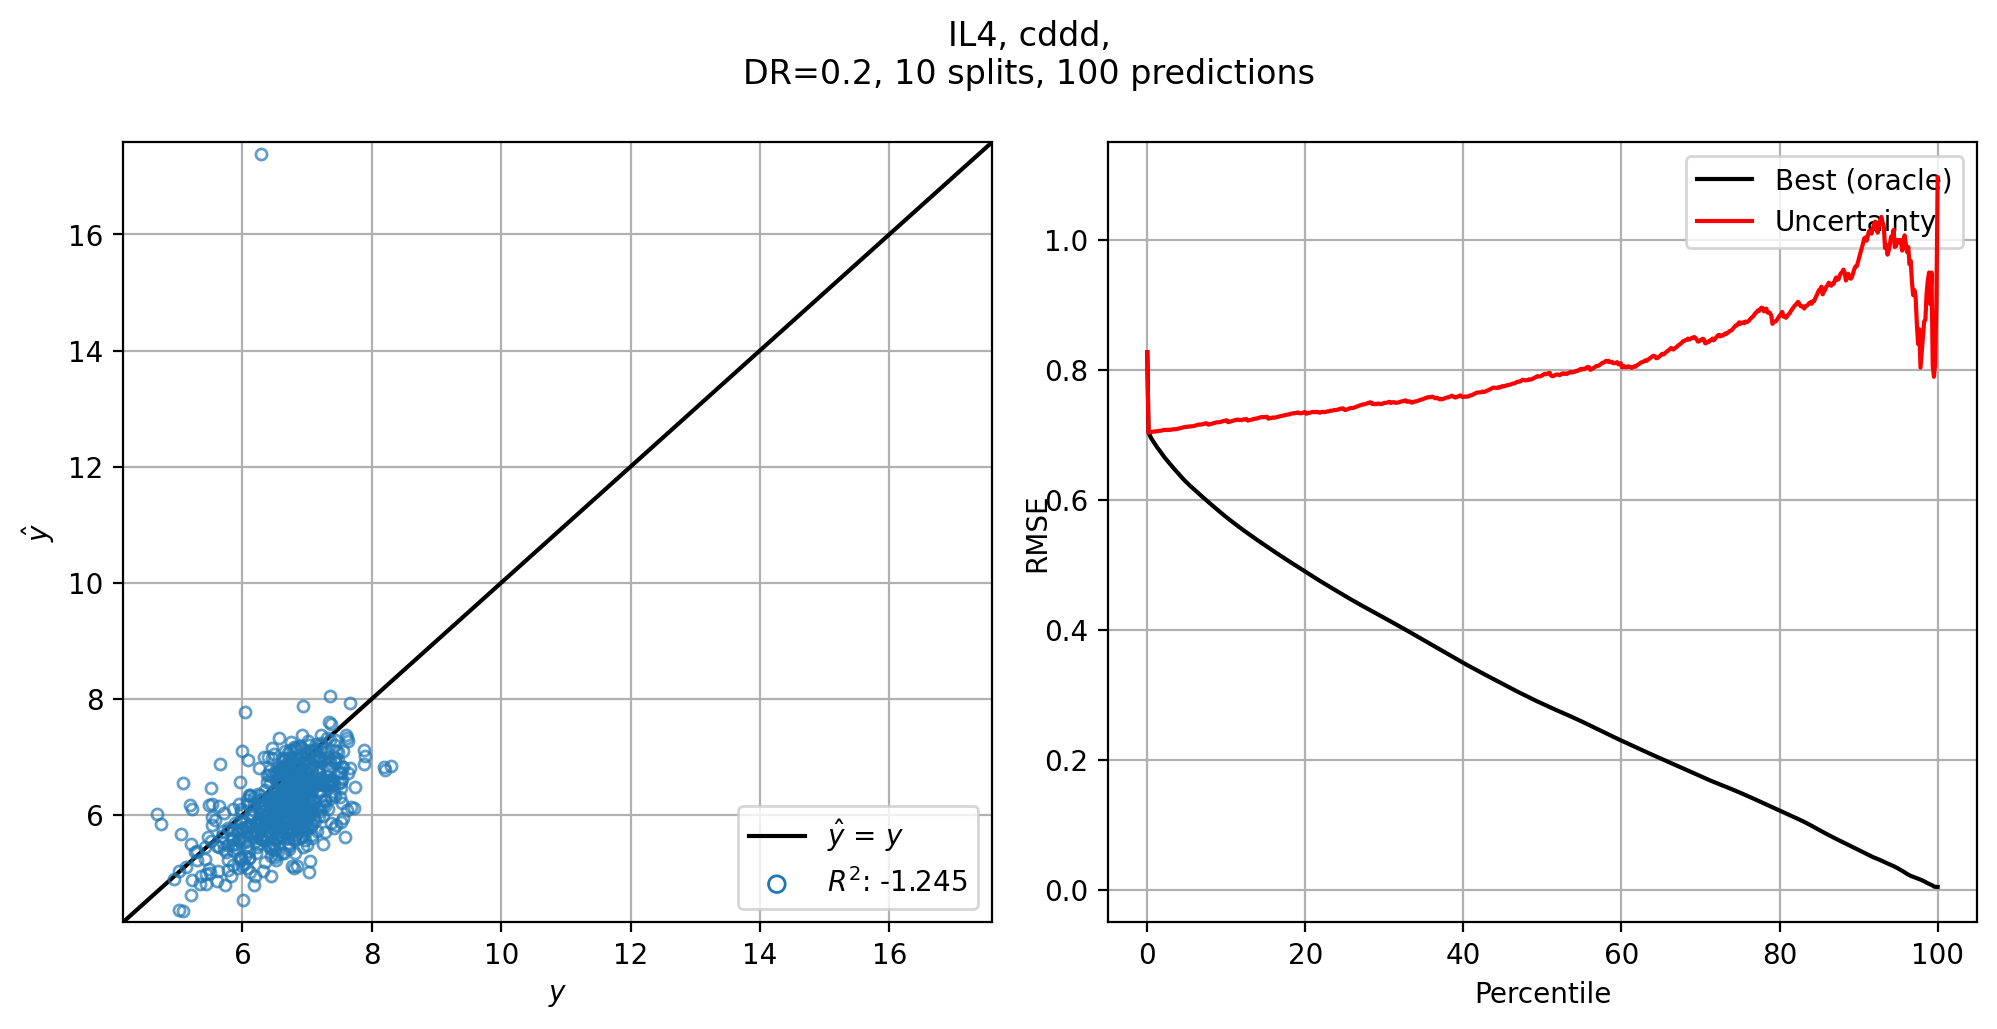

In [21]:
evaluation_automization('IL4', 'cddd')

<hr/>

#### F7, all descriptors

10it [00:42,  4.26s/it]


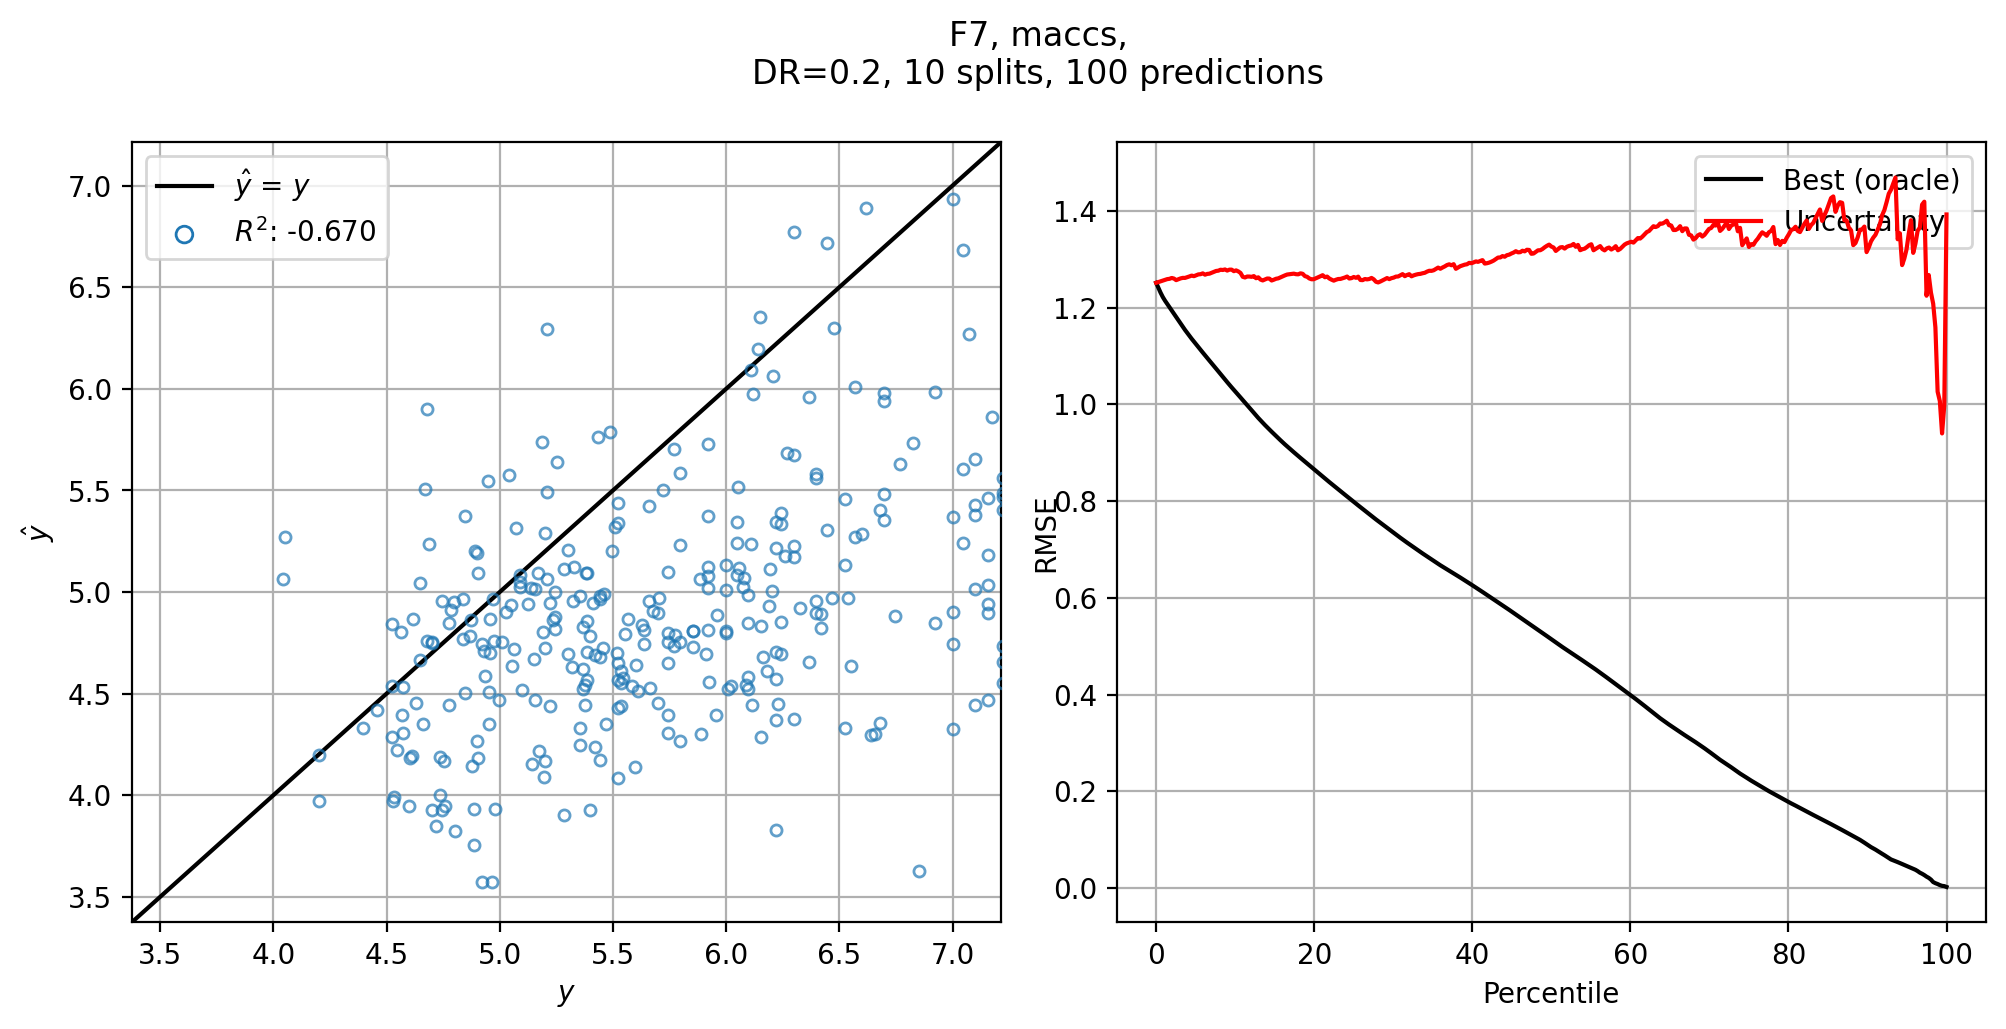

In [22]:
evaluation_automization('F7', 'maccs', scale=False)

10it [00:44,  4.43s/it]


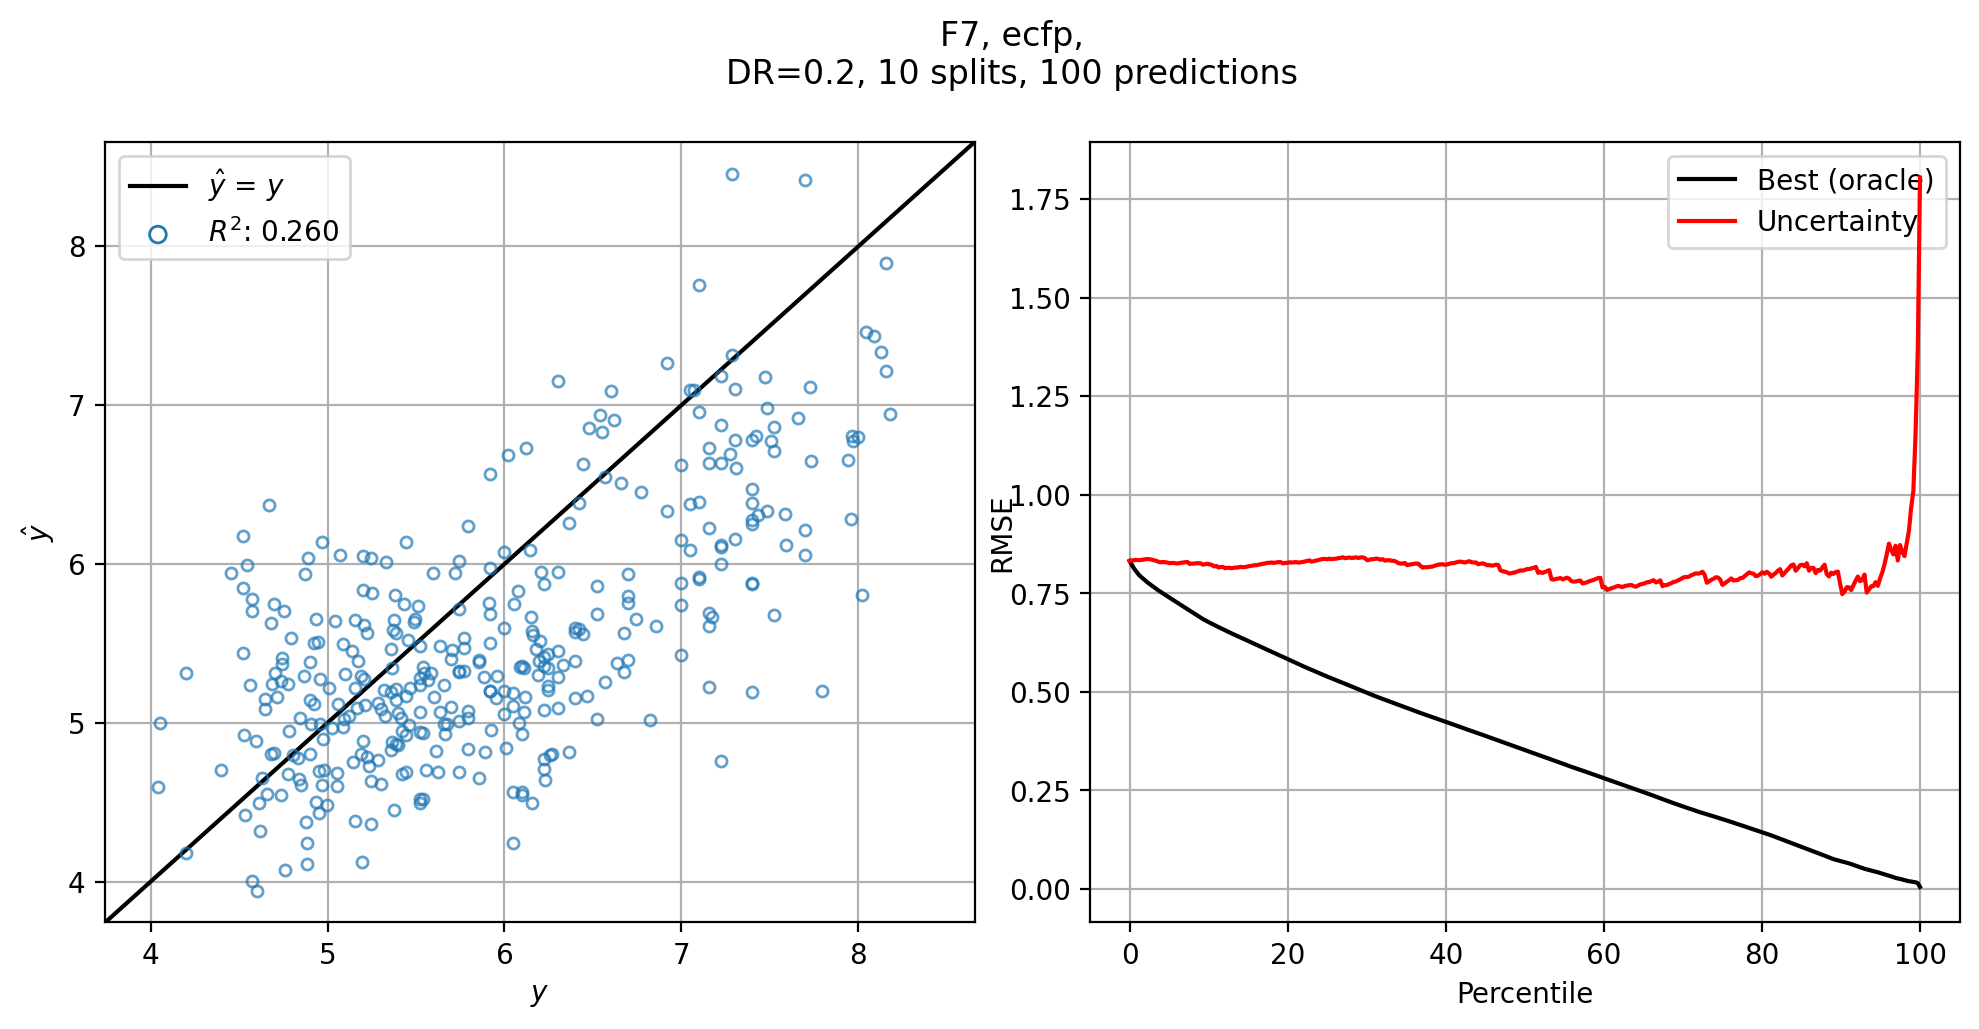

In [23]:
evaluation_automization('F7', 'ecfp', scale=False)

10it [00:35,  3.59s/it]


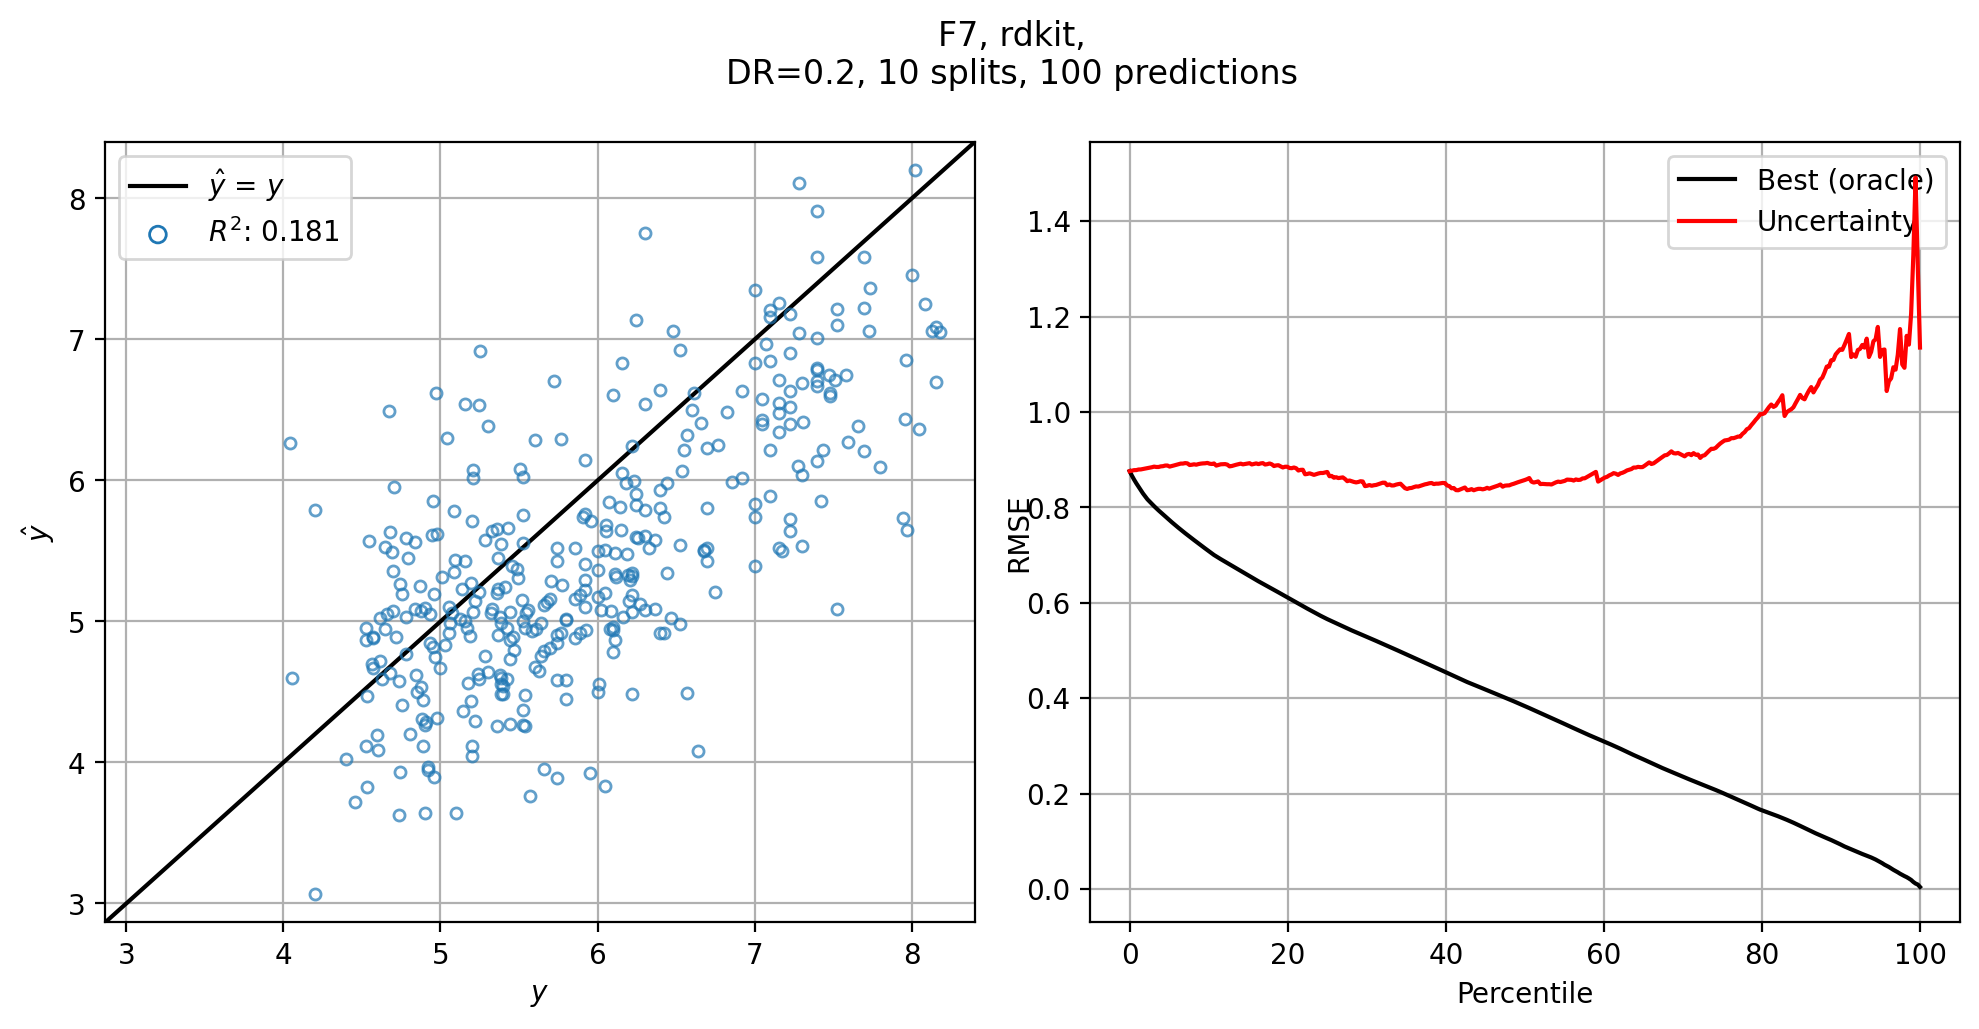

In [24]:
evaluation_automization('F7', 'rdkit')

10it [00:38,  3.82s/it]


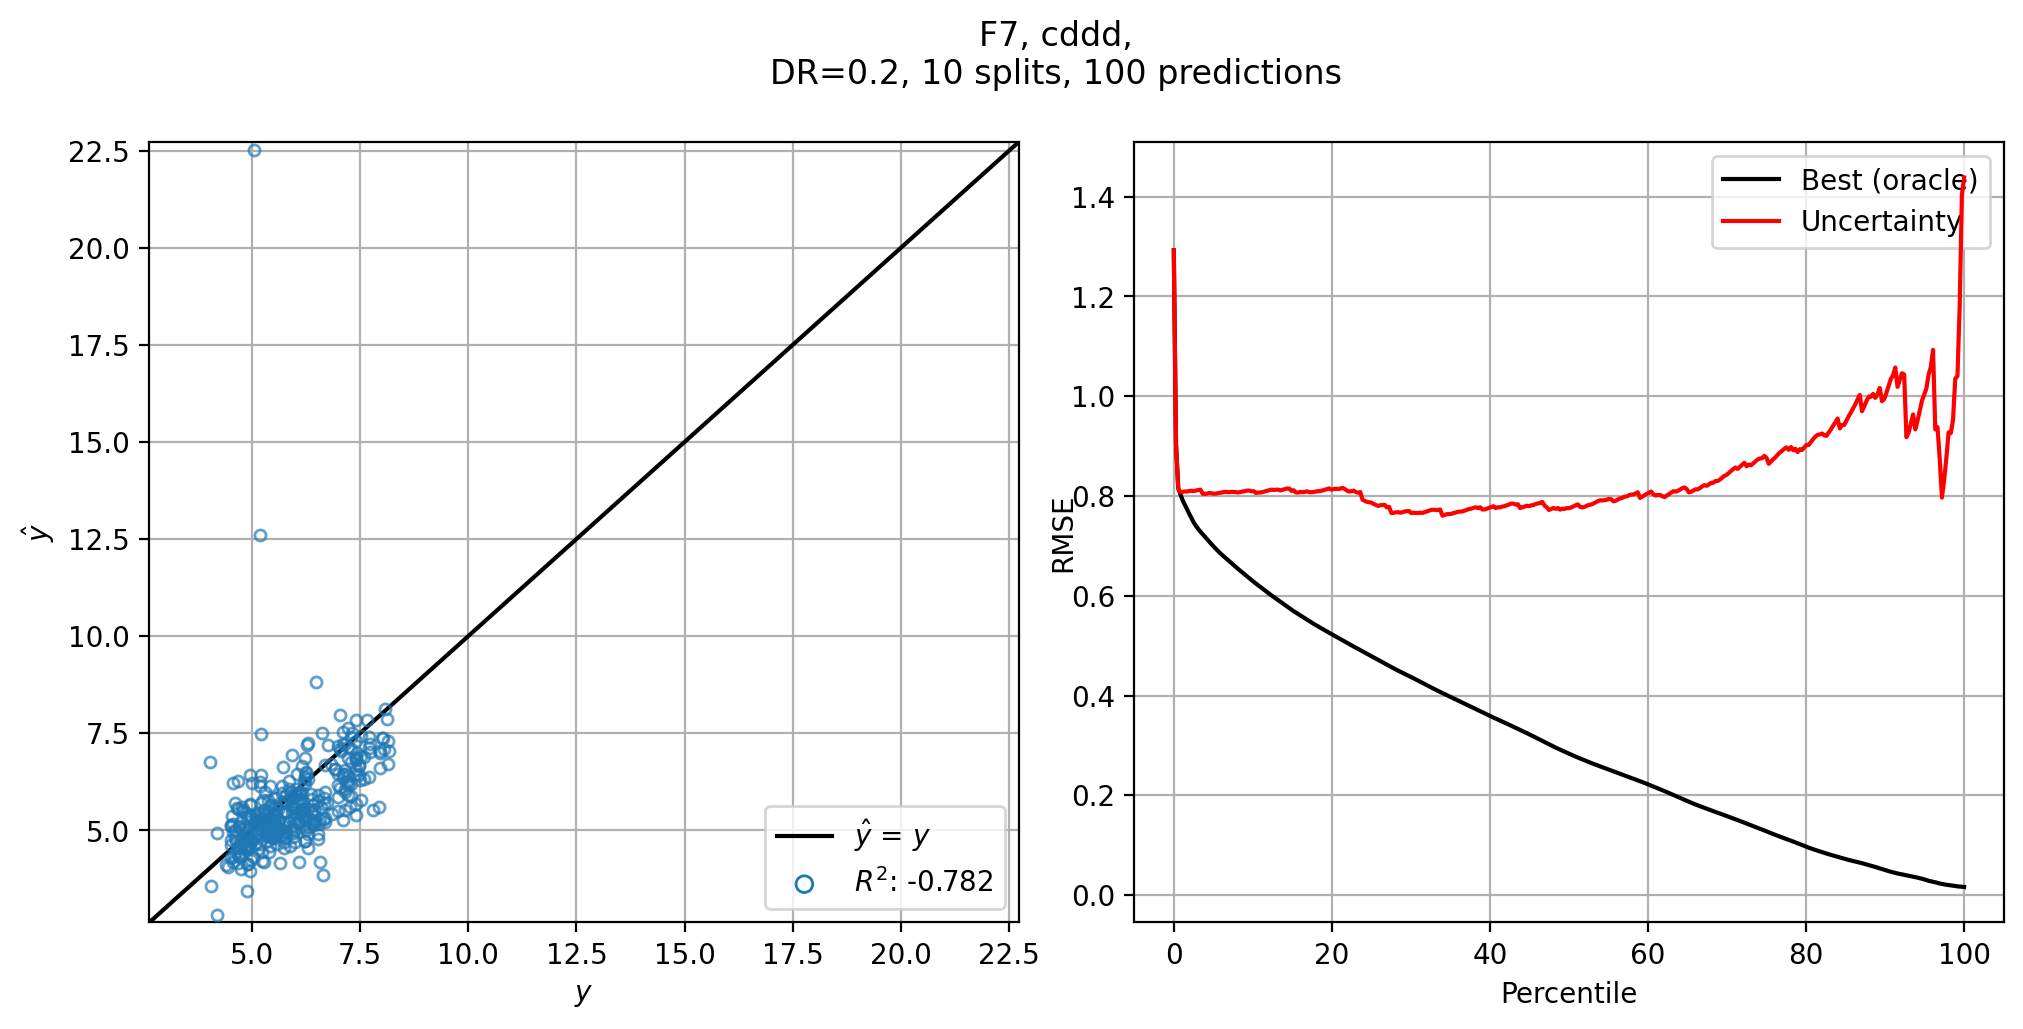

In [25]:
evaluation_automization('F7', 'cddd')

<hr/>

#### O14965, all descriptors

10it [01:03,  6.38s/it]


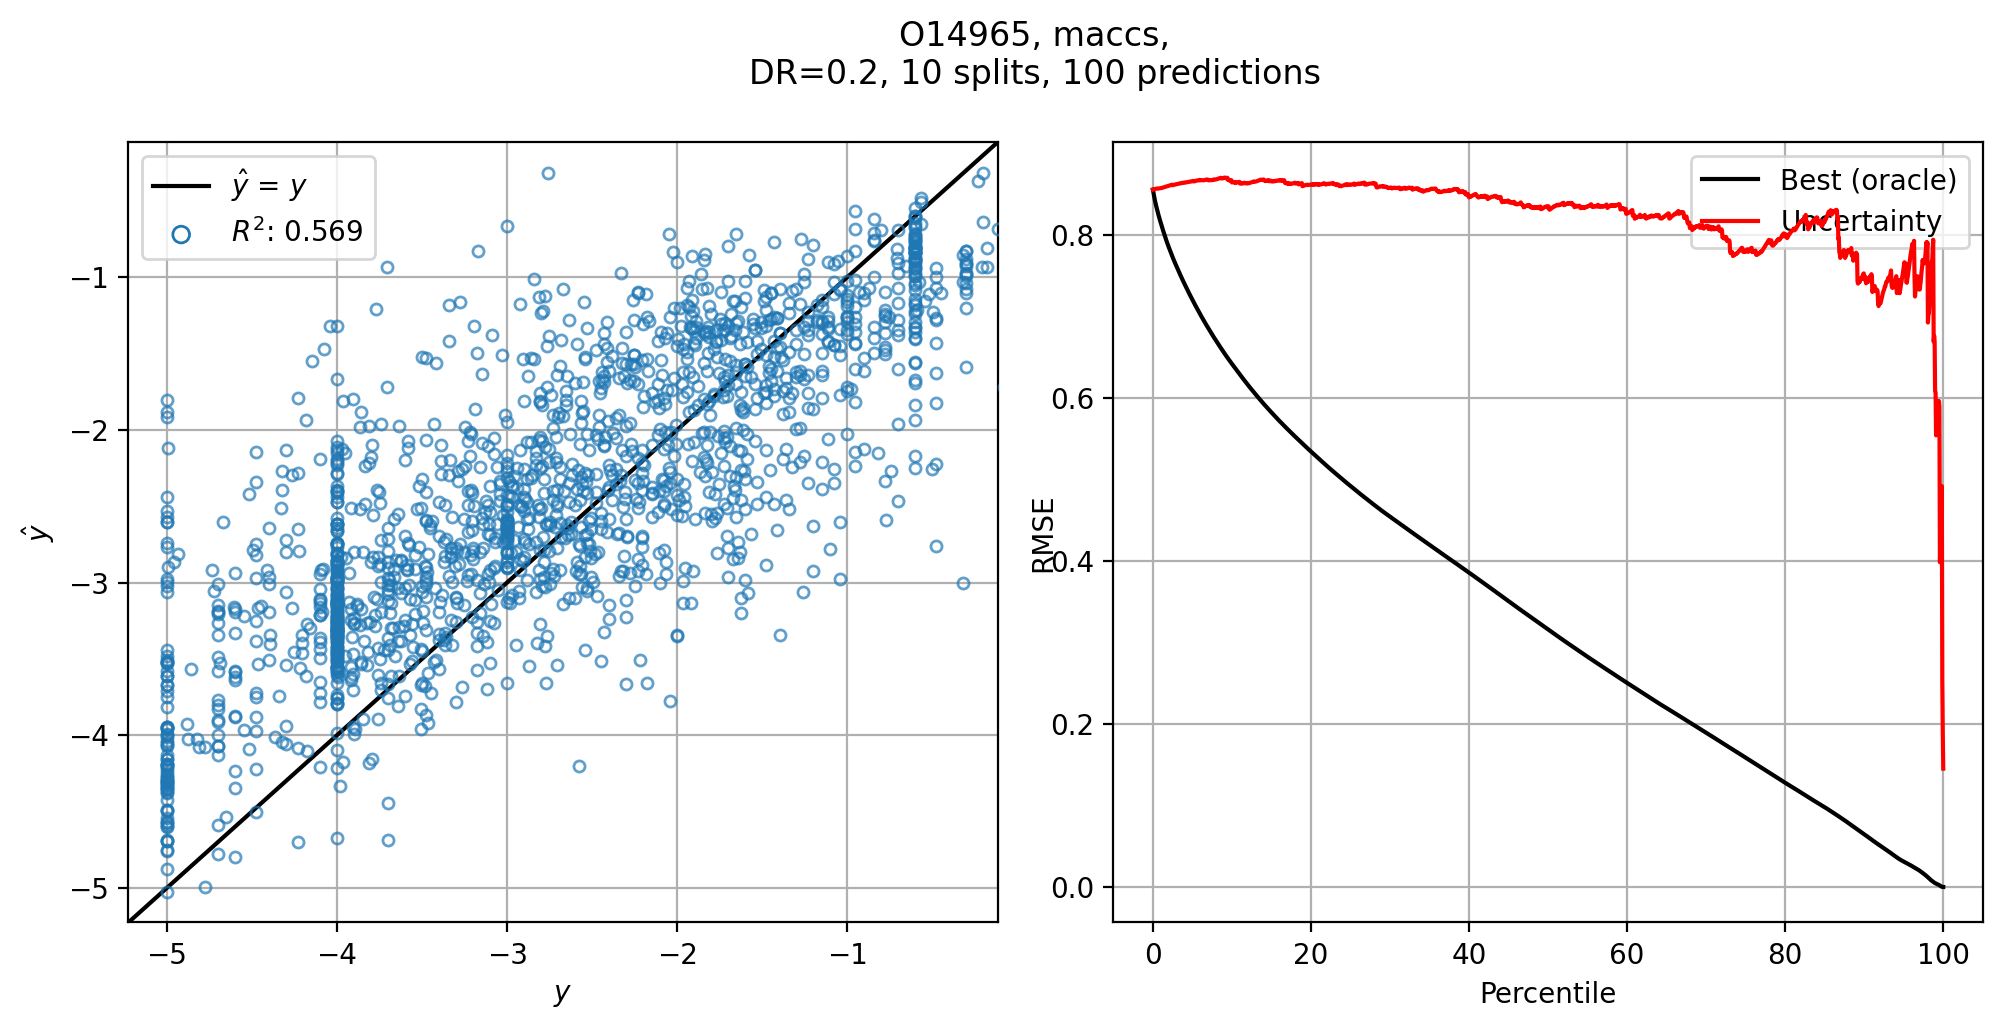

In [26]:
evaluation_automization('O14965', 'maccs', scale=False)

10it [01:09,  6.95s/it]


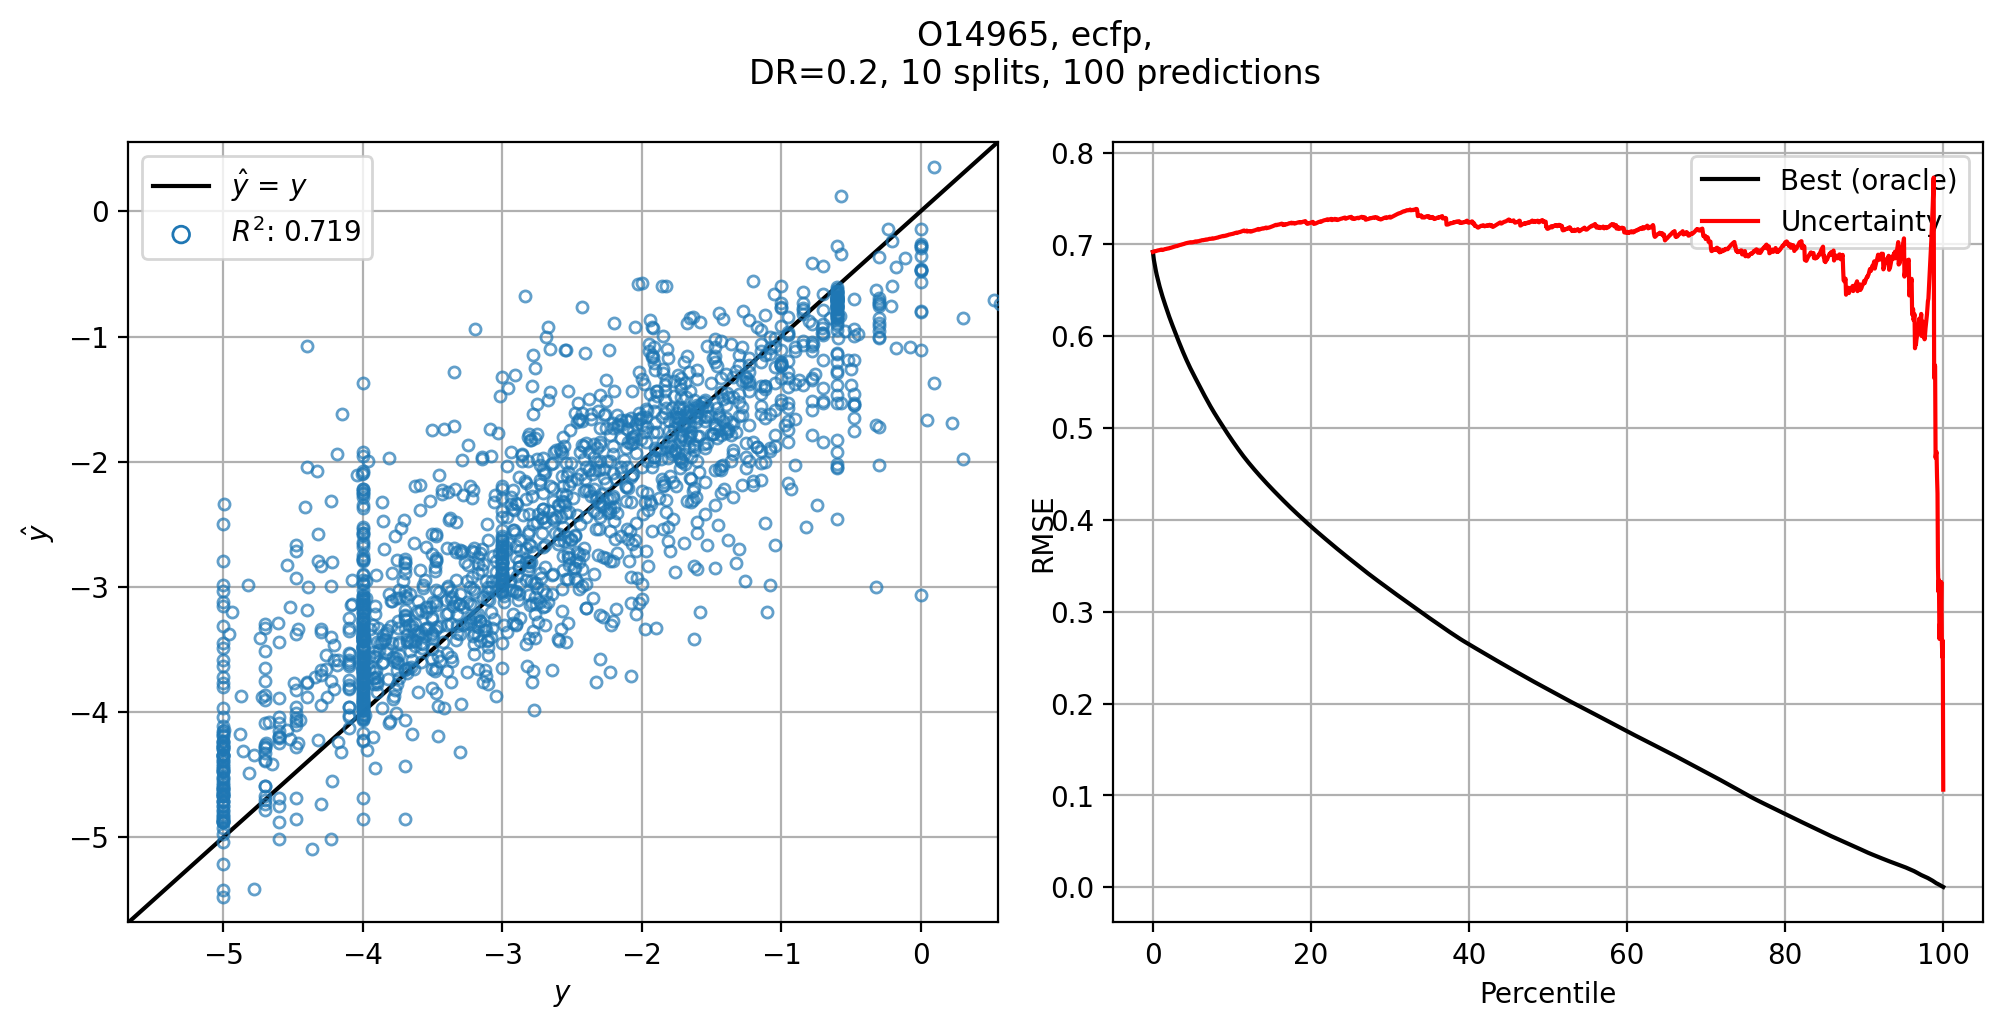

In [27]:
evaluation_automization('O14965', 'ecfp', scale=False)

10it [01:00,  6.03s/it]


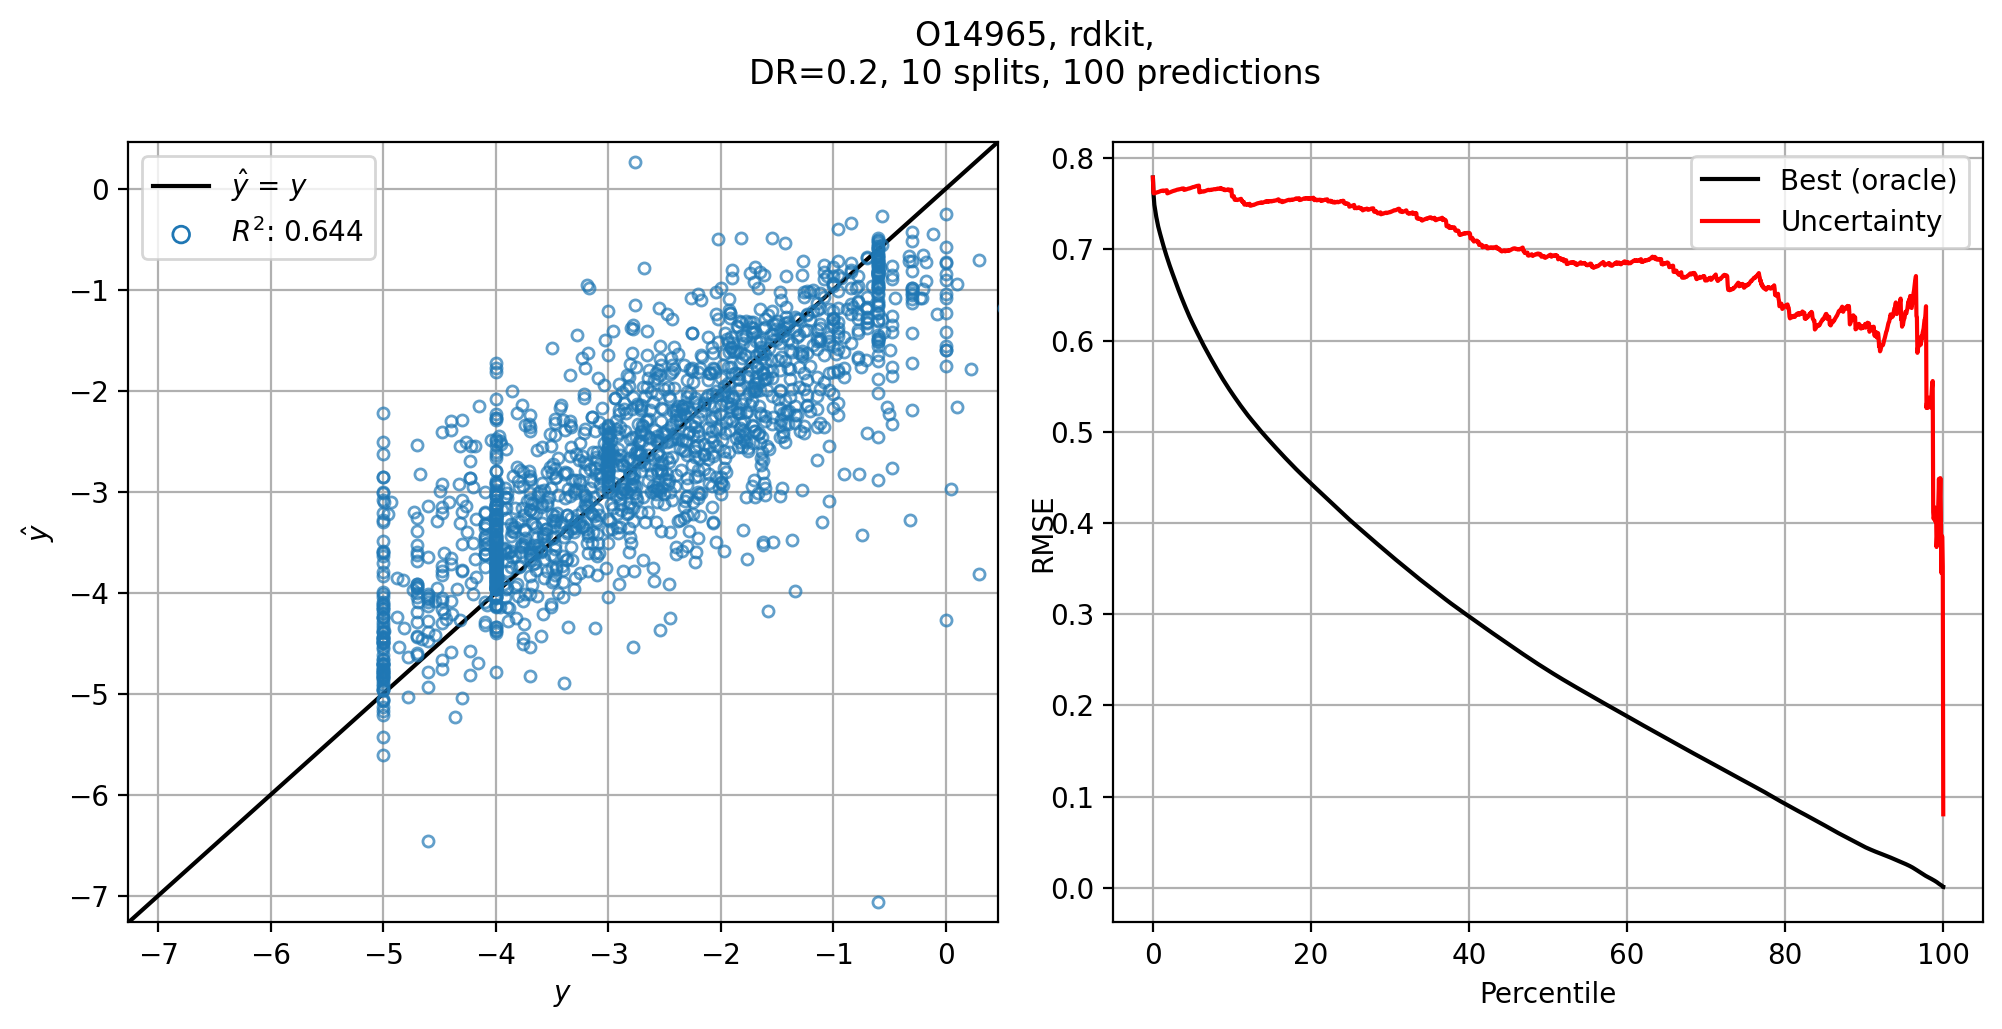

In [28]:
evaluation_automization('O14965', 'rdkit')

10it [01:02,  6.28s/it]


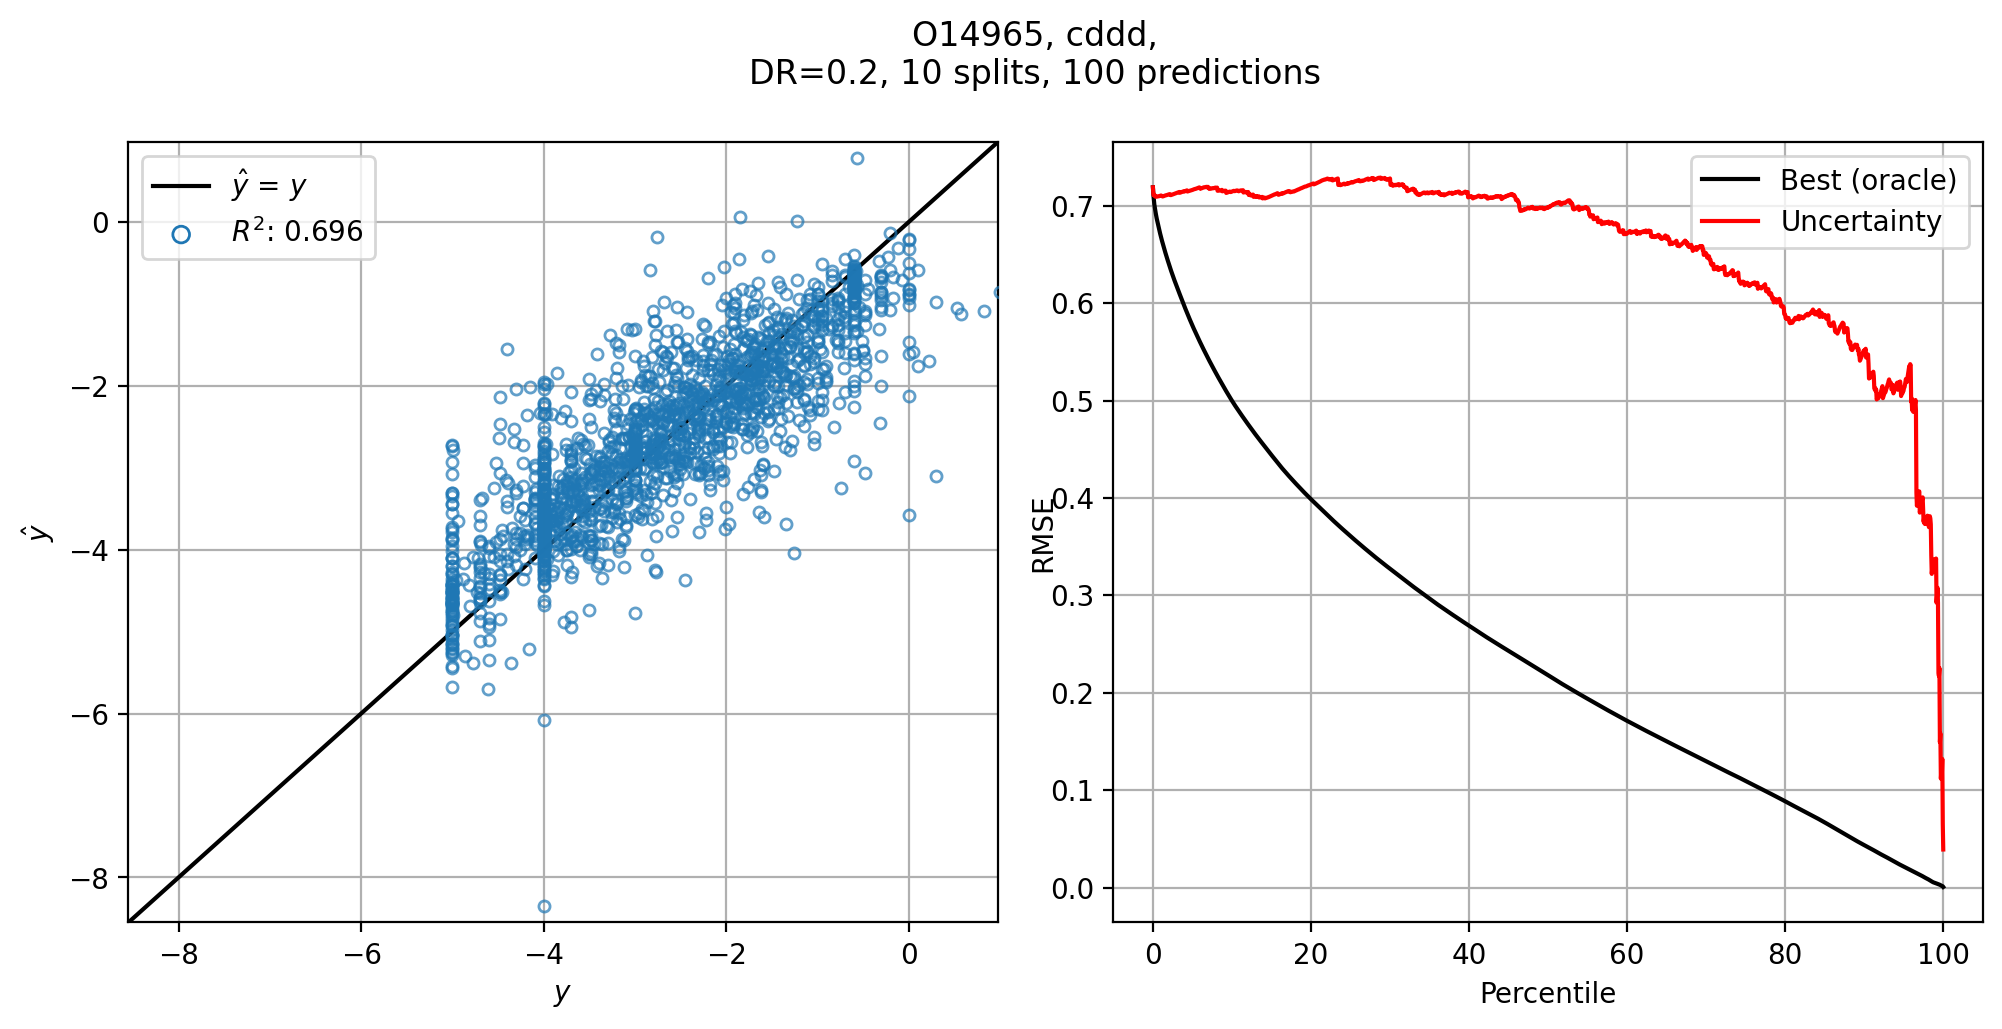

In [29]:
evaluation_automization('O14965', 'cddd')